<a href="https://colab.research.google.com/github/haytham918/low-rank-expectile/blob/main/LRE_wt_BFGS_Simulates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from scipy.stats import norm
from scipy.optimize import minimize
import time


In [123]:
def normal_data_generator(m, n, r_sd, c_sd, u_sd, v_sd, sigma, na_portion, rank, random_seed):
  """
  Generator function for normal simulated data:
  m: The Number of Rows of Feature Matrix(i.e. number of users)
  n: The Number of Columns of Feature Matrix(i.e. number of items)
  r_sd: The standard deviation of true_r
  c_sd: The standard deviation of true_c
  u_sd: The standard deviation of true_u
  v_sd: The standard deviation of true_v
  sigma: The noise standard deviation
  na_proportion: Proportion of missing data
  rank: (k), The rank for model
  random_seed: self-explained
  """
  np.random.seed(random_seed)
  k = rank

  true_r = norm.rvs(loc=0, size=m, scale=r_sd)
  true_c = norm.rvs(loc=0, size=m, scale=c_sd)

  true_u = norm.rvs(loc=0, size=(m, k), scale=u_sd)
  true_v = norm.rvs(loc=0, size=(n, k), scale=v_sd)

  sigma = sigma

  mu_X = true_r[:, np.newaxis] + true_c + np.dot(true_u, true_v.T)

  error = sigma * norm.rvs(size=(m, n))
  X = mu_X + error

  prob_miss = na_portion
  missing = np.random.choice([True, False], size=(m, n), p=[prob_miss, 1 - prob_miss])
  X[missing] = np.nan
  return X, true_r, true_c, true_u, true_v

def get_normalized_X(m, n, r_sd, c_sd, u_sd, v_sd, sigma, na_portion, rank):
  X_config, true_r_config, true_c_config, true_u_config, true_v_config = normal_data_generator(m=200, n=200, r_sd=1, c_sd=1, u_sd=1, v_sd=1,sigma=0.3,na_portion=0.3,rank=2,random_seed=100)
  #plt.hist(np.dot(true_u, true_v.T).flat)
  #plt.hist((true_r[:, np.newaxis] + true_c ).flat)
  masked_array = np.ma.masked_array(X_config, np.isnan(X_config))
  # X_nona = X[M]
  mean_nona = np.mean(masked_array)
  std_val = np.std(masked_array)
  X_normalized = X_config - mean_nona
  X_normalized /= std_val
  print("MEAN", mean_nona)
  print("STD: ", std_val)
  print("NEW ERROR_SD: ", 0.3/std_val )
  print(X_normalized)
  X_new = np.ma.array(X_normalized, mask=np.isnan(X_normalized))
  row_mean = np.mean(X_new, 1)
  col_mean = np.mean(X_new, 0)
  print("NEW MEAN: ", np.mean(X_new))
  print("NEW STD: ", np.std(X_new))
  return X_config, X_normalized, X_new, true_r_config, true_c_config, true_u_config, true_v_config, row_mean, col_mean

In [124]:
def get_observed_mask(X):
    return ~np.isnan(X)

def compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau):
    m, n = X.shape
    k = U.shape[1]

    # Construct approximation and error matrices
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    # Get weight
    W = np.where(error_matrix >= 0, tau, 1 - tau)

    # Calculate gradient
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    return R_grad, C_grad, U_grad, V_grad

def expectile_loss_vectorized(X, R, C, U, V, M, tau):
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()

    return loss

def expectile_gradient_descent_vectorized(X, k, epochs, eta, tau):
    m, n = X.shape
    R = np.zeros(m)
    C = np.zeros(n)
    U = np.random.normal(0, 0.1, (m, k))
    V = np.random.normal(0, 0.1, (n, k))
    M = get_observed_mask(X)

    for epoch in range(epochs):
        R_grad, C_grad, U_grad, V_grad = compute_expectile_gradients_vectorized(X, R, C, U, V, M, tau)
        R -= eta * R_grad
        C -= eta * C_grad
        U -= eta * U_grad
        V -= eta * V_grad

        if epoch % 10 == 9:
            current_loss = expectile_loss_vectorized(X, R, C, U, V, M, tau)
            print(f"Epoch {epoch+1}: Loss = {current_loss}")

    return R, C, U, V

In [125]:
def flatten_parameters(R, C, U, V):
    return np.concatenate([R, C, U.flatten(), V.flatten()])

def unflatten_parameters(params, m, n, k):
    R = params[:m]
    C = params[m:m+n]
    U = params[m+n:m+n+m*k].reshape(m, k)
    V = params[m+n+m*k:].reshape(n, k)
    return R, C, U, V

def total_loss_and_gradient(params, X, M, tau, m, n, k, loss_array):
    R, C, U, V = unflatten_parameters(params, m, n, k)
    approx_matrix = R[:, np.newaxis] + C + U @ V.T
    error_matrix = X - approx_matrix
    error_matrix[~M] = 0  # Ignore missing values

    W = np.where(error_matrix >= 0, tau, 1 - tau)
    loss = np.sum(W * error_matrix**2) / M.sum()
    loss_array.append(loss)
    R_grad = -2 * np.sum(W * error_matrix, axis=1) / M.sum()
    C_grad = -2 * np.sum(W * error_matrix, axis=0) / M.sum()
    U_grad = -2 * (W * error_matrix) @ V / M.sum()
    V_grad = -2 * (W * error_matrix).T @ U / M.sum()

    grad = flatten_parameters(R_grad, C_grad, U_grad, V_grad)
    return loss, grad

# BFGS METHOD, set method to "L-BFGS-B" for LBFGS
# Init all parameters one time
def optimize_with_bfgs_all_init(X, k, tau, loss_array, mu, sd, method="BFGS"):

    m, n = X.shape
    M = get_observed_mask(X)
    initial_params = np.random.normal(mu, sd, m + n + m*k + n*k)

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method=method, jac=True, options={'disp': False, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"{method} Final Loss: {final_loss}")
    return R, C, U, V

# Initi parameters separately
def optimize_with_bfgs_sep_init(X, k, tau, loss_array, row_mean, col_mean, u_mu, u_sd, v_mu, v_sd, method="BFGS"):
    m, n = X.shape
    M = get_observed_mask(X)
    initial_r_param = row_mean
    initial_c_param = col_mean
    initial_uv_param = np.random.normal(u_mu, u_sd, m*k + n*k)
    initial_params = np.concatenate((initial_r_param, initial_c_param, initial_uv_param))

    result = minimize(total_loss_and_gradient, initial_params, args=(X, M, tau, m, n, k, loss_array),
                      method=method, jac=True, options={'disp': False, "maxiter": 500})

    final_params = result.x
    final_loss = result.fun
    R, C, U, V = unflatten_parameters(final_params, m, n, k)
    print(f"{method} Final Loss: {final_loss}")
    return R, C, U, V


In [126]:
def runner_all_init(setup_num, config_matrix, rank, tau, loss_array, lbfgs_loss_array, mu, sd):
  start_time = time.time()
  R, C, U, V = optimize_with_bfgs_all_init(config_matrix, rank, tau, loss_array, mu, sd)
  end_time = time.time()
  bfgs_iter_num = len(loss_array)
  print(f"Trial {setup_num} BFGS Takes about: ", end_time - start_time, " (s)")
  print(f"Trial {setup_num} BFGS Iterations: ", bfgs_iter_num)
  print("------------------------------------")

  # LBFGS
  lbfgs_start_time = time.time()
  lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V = optimize_with_bfgs_all_init(config_matrix, rank, tau, lbfgs_loss_array, mu, sd, "L-BFGS-B")
  lbfgs_end_time = time.time()
  lbfgs_iter_num = len(lbfgs_loss_array)
  print(f"Trial {setup_num} LBFGS Takes about: ", lbfgs_end_time - lbfgs_start_time, " (s)")
  print(f"Trial {setup_num} LBFGS Iterations: ", lbfgs_iter_num)
  print("")

  return R, C, U, V, lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V

def runner_sep_init(setup_num, config_matrix, rank, tau, loss_array, lbfgs_loss_array, row_mean, col_mean, u_mu, u_sd, v_mu, v_sd):
  start_time = time.time()
  R, C, U, V = optimize_with_bfgs_sep_init(config_matrix, rank, tau, loss_array, row_mean, col_mean, u_mu, u_sd, v_mu, v_sd)
  end_time = time.time()
  bfgs_iter_num = len(loss_array)
  print(f"SETUP {setup_num} BFGS Takes about: ", end_time - start_time, " (s)")
  print(f"SETUP {setup_num} BFGS Iterations: ", bfgs_iter_num)
  print("------------------------------------")

  # LBFGS
  lbfgs_start_time = time.time()
  lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V = optimize_with_bfgs_sep_init(config_matrix, rank, tau, lbfgs_loss_array, row_mean, col_mean, u_mu, u_sd, v_mu, v_sd, "L-BFGS-B")
  lbfgs_end_time = time.time()
  lbfgs_iter_num = len(lbfgs_loss_array)
  print(f"SETUP {setup_num} LBFGS Takes about: ", lbfgs_end_time - lbfgs_start_time, " (s)")
  print(f"SETUP {setup_num} LBFGS Iterations: ", lbfgs_iter_num)
  print("")
  return R, C, U, V, lbfgs_R, lbfgs_C, lbfgs_U, lbfgs_V

def plotter(setup_num, loss_array, lbfgs_loss_array):
  bfgs_horizontal = np.arange(1, len(loss_array) + 1)
  lbfgs_horizontal = np.arange(1, len(lbfgs_loss_array) + 1)
  bfgs_log = np.log(loss_array)
  lbfgs_log = np.log(np.array(lbfgs_loss_array))
  fig, axs = plt.subplots(1, 2, figsize=(10,5))
  axs[0].set_ylabel("LOSS")
  axs[0].set_xlabel("Number of Iterations")
  axs[0].set_title(f"Trial {setup_num}'s LOSS v.s. Iterations")
  axs[0].plot(bfgs_horizontal, loss_array, label="BFGS", color='r')
  axs[0].plot(lbfgs_horizontal, lbfgs_loss_array, label="LBFGS", color='b')
  axs[0].legend()


  axs[1].set_ylabel("LOG LOSS")
  axs[1].set_xlabel("Number of Iterations")
  axs[1].set_title(f"Trial {setup_num}'s LOG LOSS v.s. Iterations")
  axs[1].plot(bfgs_horizontal, bfgs_log, label="BFGS", color='r')
  axs[1].plot(lbfgs_horizontal, lbfgs_log, label="LBFGS", color='b')
  axs[1].legend()

In [127]:


def run_algorithm_ten_trials_all_init(X_normalized, rank, tau, mu=1, sd=1):
  all_bfgs_loss_arrays = []
  all_lbfgs_loss_arrays = []
  all_bfgs_final_loss = []
  all_lbfgs_final_loss = []
  all_bfgs_predict_array = []
  all_lbfgs_predict_array = []
  for i in range(10):
    bfgs_loss_array = []
    lbfgs_loss_array = []
    R, C, U, V, l_R, l_C, l_U, l_V = runner_all_init(i, X_normalized, rank, tau, bfgs_loss_array, lbfgs_loss_array, mu, sd)
    all_bfgs_final_loss.append(bfgs_loss_array[-1])
    all_lbfgs_final_loss.append(lbfgs_loss_array[-1])
    all_bfgs_loss_arrays.append(bfgs_loss_array)
    all_lbfgs_loss_arrays.append(lbfgs_loss_array)

    X_hat = R[:,np.newaxis] + C + U @ V.T
    all_bfgs_predict_array.append(X_hat)

    X_hat_l = l_R[:,np.newaxis] + l_C + l_U @ l_V.T
    all_lbfgs_predict_array.append(X_hat_l)
  return all_bfgs_loss_arrays, all_lbfgs_loss_arrays, all_bfgs_final_loss, all_lbfgs_final_loss, all_bfgs_predict_array, all_lbfgs_predict_array

def run_algorithm_ten_trials_sep_init(X_normalized, rank, tau, row_mean, col_mean, mu=1, sd=1):
  all_bfgs_loss_arrays = []
  all_lbfgs_loss_arrays = []
  all_bfgs_final_loss = []
  all_lbfgs_final_loss = []
  all_bfgs_predict_array = []
  all_lbfgs_predict_array = []
  for i in range(10):
    bfgs_loss_array = []
    lbfgs_loss_array = []
    R, C, U, V, l_R, l_C, l_U, l_V = runner_sep_init(i, X_normalized, rank, tau, bfgs_loss_array, lbfgs_loss_array,row_mean, col_mean, u_mu=0, u_sd=1, v_mu=0, v_sd=1)
    all_bfgs_final_loss.append(bfgs_loss_array[-1])
    all_lbfgs_final_loss.append(lbfgs_loss_array[-1])
    all_bfgs_loss_arrays.append(bfgs_loss_array)
    all_lbfgs_loss_arrays.append(lbfgs_loss_array)

    X_hat = R[:,np.newaxis] + C + U @ V.T
    all_bfgs_predict_array.append(X_hat)

    X_hat_l = l_R[:,np.newaxis] + l_C + l_U @ l_V.T
    all_lbfgs_predict_array.append(X_hat_l)
  return all_bfgs_loss_arrays, all_lbfgs_loss_arrays, all_bfgs_final_loss, all_lbfgs_final_loss, all_bfgs_predict_array, all_lbfgs_predict_array



In [156]:
# Plots for the 10 trials
def HeatMap_Loss(bfgs_final_loss, lbfgs_final_loss, tau, rank):
  figure, axes = plt.subplots(1, 2, figsize=(10,5))

  # BFGS FINAL LOSS
  bfgs_final_loss = np.array(bfgs_final_loss)
  bfgs_difference_matrix = np.abs(bfgs_final_loss[:, np.newaxis] - bfgs_final_loss[np.newaxis, :])
  bfgs_loss_heatmap = axes[0].imshow(bfgs_difference_matrix, cmap="viridis", interpolation="nearest")
  axes[0].set_title(f"HeatMap of Final BFGS Loss Between Pairs of Trials(Tau: {tau}, Rank: {rank})", fontsize=8)
  axes[0].set_xlabel("Trial Number")
  axes[0].set_ylabel("Trial Number")
  bfgs_loss_cbar = figure.colorbar(bfgs_loss_heatmap, ax=axes[0], orientation="horizontal")

  # LBFGS FINAL LOSS HEATMAP
  lbfgs_final_loss = np.array(lbfgs_final_loss)
  lbfgs_difference_matrix = np.abs(lbfgs_final_loss[:, np.newaxis] - lbfgs_final_loss[np.newaxis, :])
  lbfgs_loss_heatmap = axes[1].imshow(lbfgs_difference_matrix, cmap="viridis", interpolation="nearest")
  axes[1].set_title(f"HeatMap of Final L-BFGS Loss Between Pairs of Trials(Tau: {tau}, Rank: {rank})", fontsize=8)
  axes[1].set_xlabel("Trial Number")
  axes[1].set_ylabel("Trial Number")
  lbfgs_loss_cbar = figure.colorbar(lbfgs_loss_heatmap, ax=axes[1], orientation="horizontal")

# HeatMap of Differences between predicted X matrix
def HeatMap_Diff(bfgs_predict_array, lbfgs_predict_array, tau, rank, m=200, n=200):
  predict_figure, predict_axis = plt.subplots(1, 2, figsize=(10,5))

  # BFGS Predicted X Difference
  bfgs_sum_of_diffs = np.zeros((10,10))
  for x in range(10):
    for y in range(x+1, 10):
      abs_bfgs_diff = np.abs(bfgs_predict_array[x] - bfgs_predict_array[y])
      bfgs_sum_of_diffs[x, y] = np.sum(abs_bfgs_diff) / (m*n)
      bfgs_sum_of_diffs[y, x] = bfgs_sum_of_diffs[x,y]

  bfgs_predict_diff = predict_axis[0].imshow(bfgs_sum_of_diffs, cmap="viridis", interpolation="nearest")
  bfgs_predict_cbar = predict_figure.colorbar(bfgs_predict_diff, ax=predict_axis[0], orientation="horizontal")
  predict_axis[0].set_title(f"HeatMap of BFGS Mean of Differences of X-hat Between Trials(Tau: {tau}, Rank: {rank})", fontsize=7)
  predict_axis[0].set_xlabel("Trial Number")
  predict_axis[0].set_ylabel("Trial Number")

  # BFGS Predicted X Difference
  lbfgs_sum_of_diffs = np.zeros((10,10))
  for x in range(10):
    for y in range(x+1, 10):
      abs_lbfgs_diff = np.abs(lbfgs_predict_array[x] - lbfgs_predict_array[y])
      lbfgs_sum_of_diffs[x, y] = np.sum(abs_lbfgs_diff) / (m*n)
      lbfgs_sum_of_diffs[y, x] = lbfgs_sum_of_diffs[x,y]

  lbfgs_predict_diff = predict_axis[1].imshow(lbfgs_sum_of_diffs, cmap="viridis", interpolation="nearest")
  lbfgs_predict_cbar = predict_figure.colorbar(lbfgs_predict_diff, ax=predict_axis[1], orientation="horizontal")
  predict_axis[1].set_title(f"HeatMap of L-BFGS Mean of Differences of X-hat Between Trials(Tau: {tau}, Rank: {rank})", fontsize=7)
  predict_axis[1].set_xlabel("Trial Number")
  predict_axis[1].set_ylabel("Trial Number")

def Plot_HeatMap(bfgs_final_loss, lbfgs_final_loss, bfgs_predict_array, lbfgs_predict_array, tau, rank, m=200, n=200):
  HeatMap_Loss(bfgs_final_loss, lbfgs_final_loss, tau, rank)
  HeatMap_Diff(bfgs_predict_array, lbfgs_predict_array, tau, rank, m, n)

# Setup 1
Rank 2, Tau 0.1

In [129]:
#-----------------
# Configuration 1:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 2
# Tau: 0.1
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_1 = 2
tau_1 = 0.1
mu_1 = 0
sd_1 = 1
X_config_1, X_normalized_1, X_new_1, true_r_config_1, true_c_config_1, true_u_congfig_1, true_v_config_1, row_mean_1, col_mean_1 = get_normalized_X(m=200, n=200, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=rank_1)
all_bfgs_loss_arrays_1, all_lbfgs_loss_arrays_1, all_bfgs_final_loss_1, all_lbfgs_final_loss_1, all_bfgs_predict_array_1, all_lbfgs_predict_array_1 = run_algorithm_ten_trials_sep_init(X_normalized_1, rank_1, tau_1, row_mean_1, col_mean_1, mu_1, sd_1)


MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  1.2149491064578515e-17
NEW STD:  1.0
BFGS Final Loss: 0.004929789587062248
SETUP 0 BFGS Takes about:  42.19582772254944  (s)
SETUP 0 BFGS Iterations:  153
------------------------------------
L-BFGS-B Final Loss: 0.004929471420576985
SETUP 0 LBFGS Takes about:  0.0655982494354248  (s)
SETUP 0 LBFGS Iterations:  29

BFGS Final Loss: 0.004929991509443842
SETUP 1 BFGS Takes about:  40.62341594696045  (s)
SETUP 1

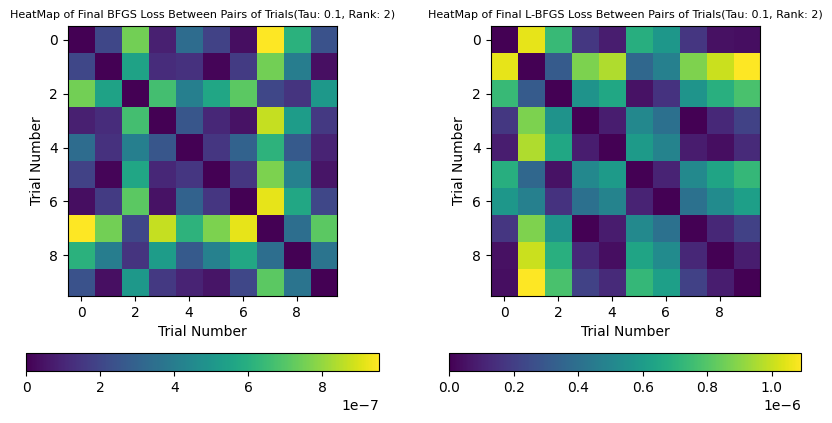

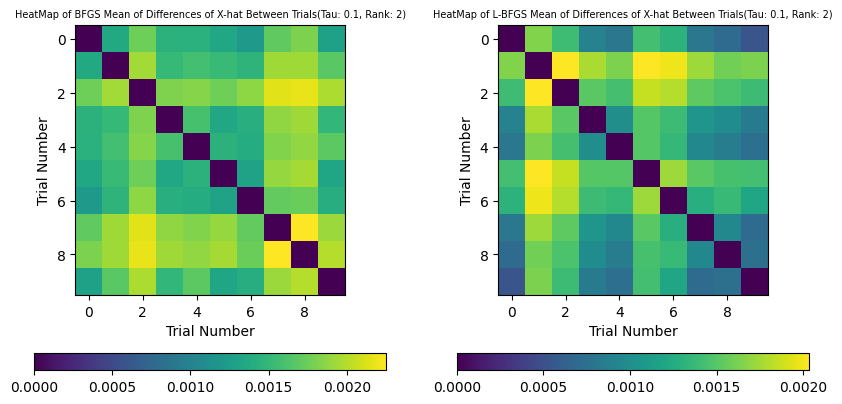

In [130]:
# First Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_1, all_lbfgs_final_loss_1, all_bfgs_predict_array_1, all_lbfgs_predict_array_1, tau_1, rank_1)

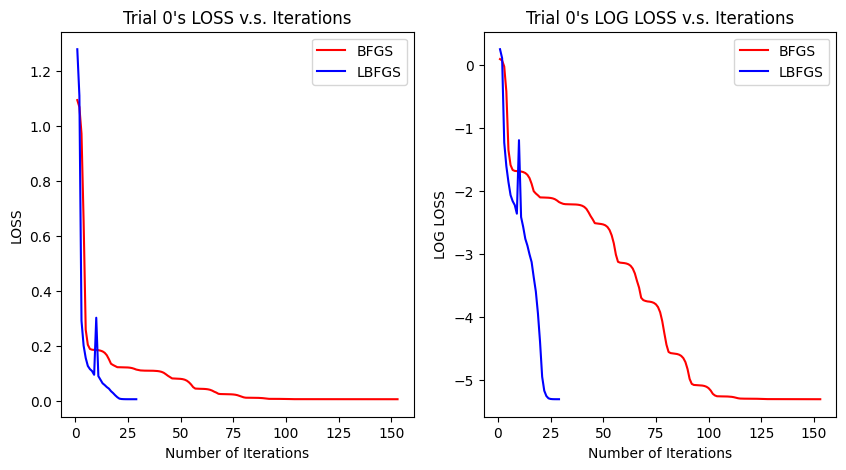

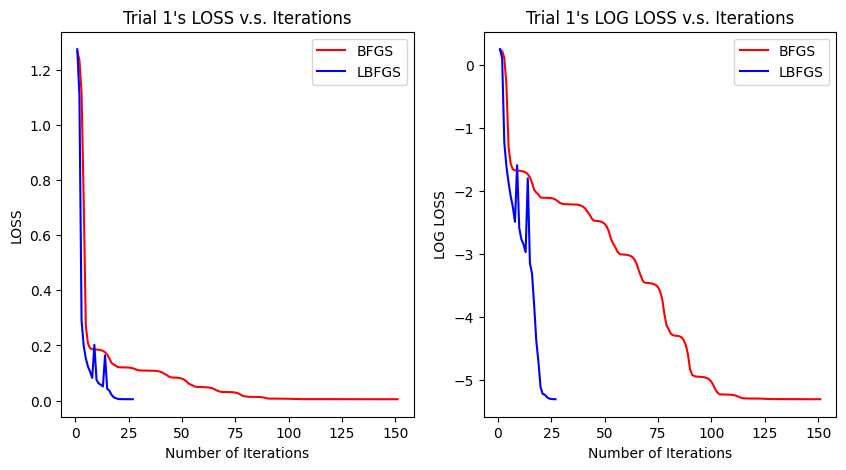

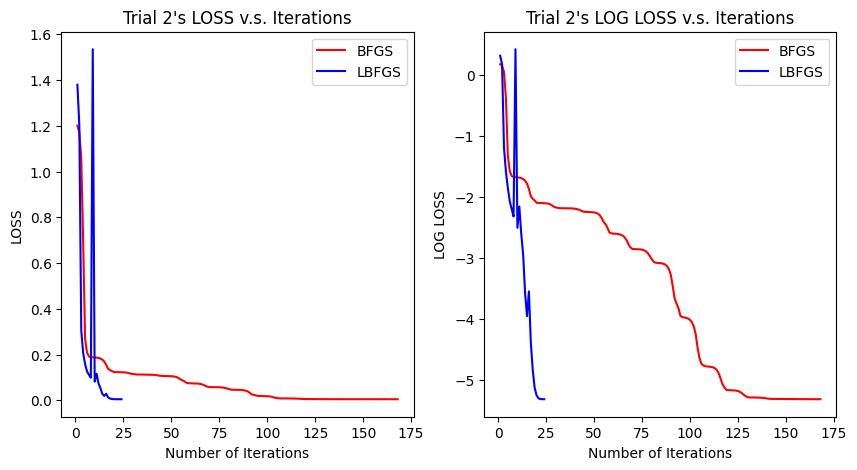

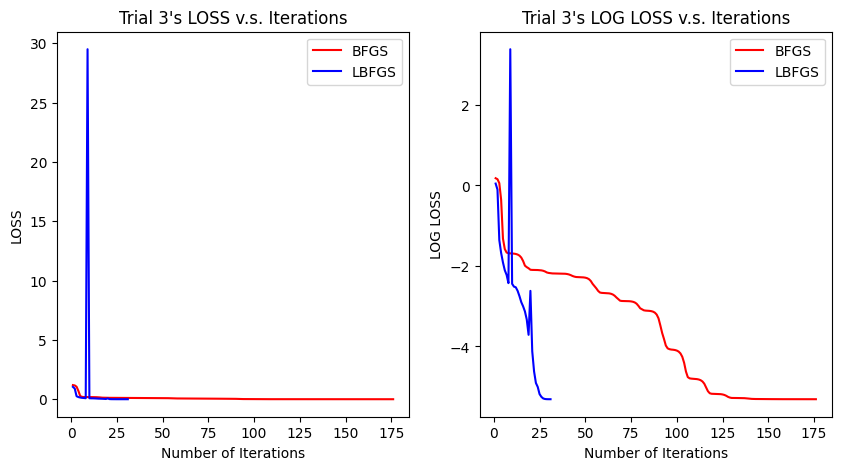

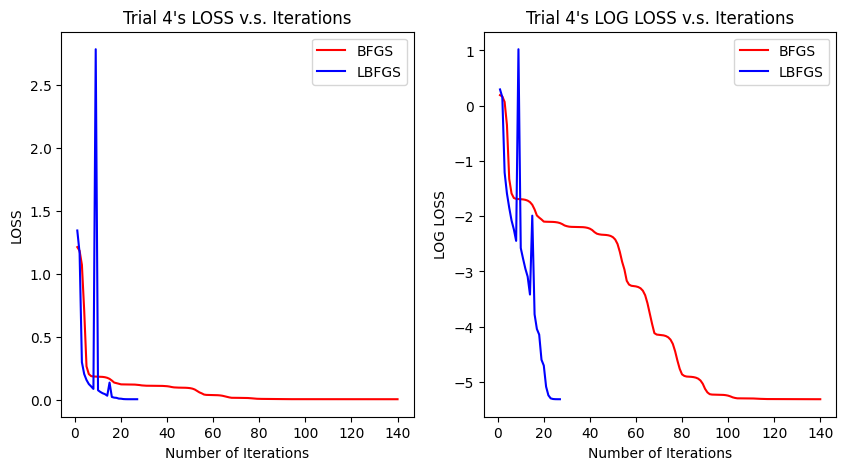

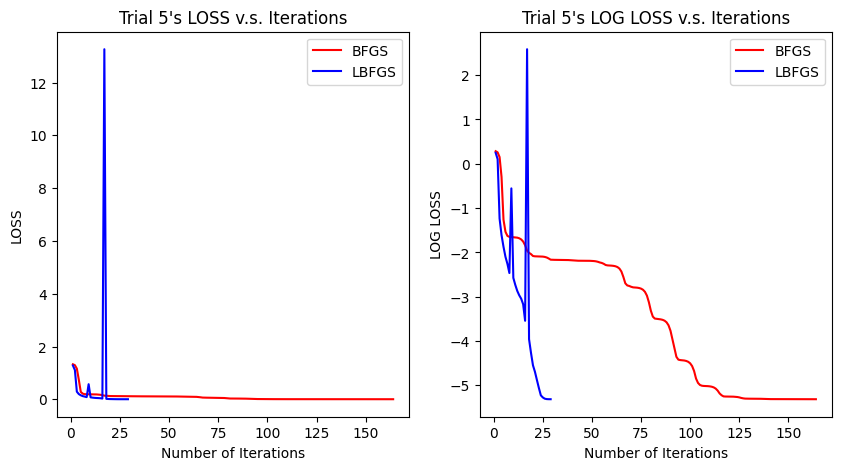

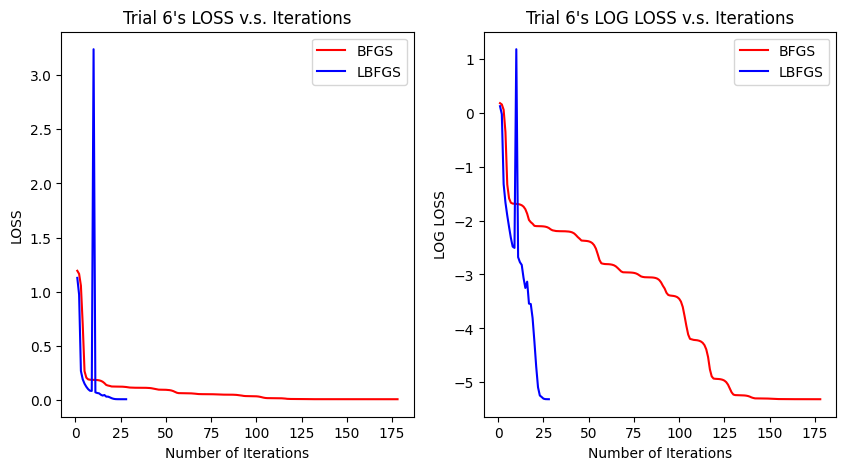

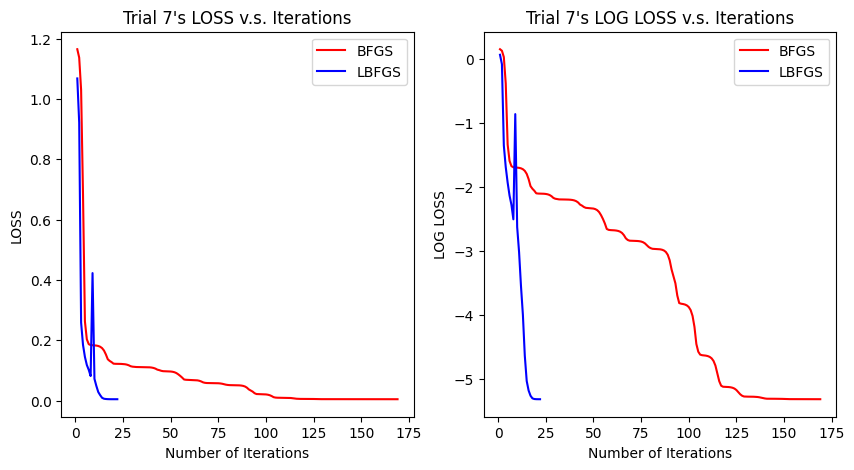

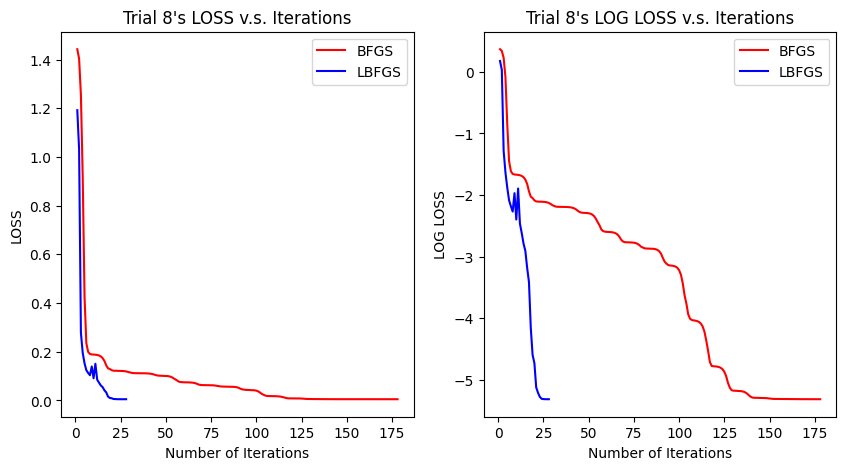

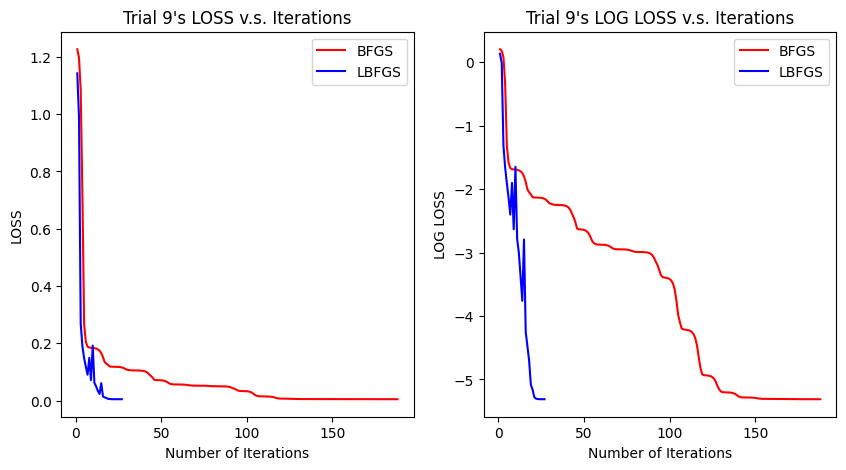

In [131]:
# SETUP 1 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_1[i], all_lbfgs_loss_arrays_1[i])

# Setup 2
Rank 1, Tau 0.1

In [132]:
#-----------------
# Configuration 2:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 1
# Tau: 0.1
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_2 = 1
tau_2 = 0.1
mu_2 = 0
sd_2 = 1
X_config_2, X_normalized_2, X_new_2, true_r_config_2, true_c_config_2, true_u_congfig_2, true_v_config_2, row_mean_2, col_mean_2 = get_normalized_X(m=200, n=200, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=rank_2)
all_bfgs_loss_arrays_2, all_lbfgs_loss_arrays_2, all_bfgs_final_loss_2, all_lbfgs_final_loss_2, all_bfgs_predict_array_2, all_lbfgs_predict_array_2 = run_algorithm_ten_trials_sep_init(X_normalized_2, rank_2, tau_2, row_mean_2, col_mean_2, mu_2, sd_2)

MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  1.2149491064578515e-17
NEW STD:  1.0
BFGS Final Loss: 0.05137325108589747
SETUP 0 BFGS Takes about:  18.64910340309143  (s)
SETUP 0 BFGS Iterations:  199
------------------------------------
L-BFGS-B Final Loss: 0.05137299960603553
SETUP 0 LBFGS Takes about:  0.15342473983764648  (s)
SETUP 0 LBFGS Iterations:  27

BFGS Final Loss: 0.061039373201555044
SETUP 1 BFGS Takes about:  13.895078897476196  (s)
SETUP 1

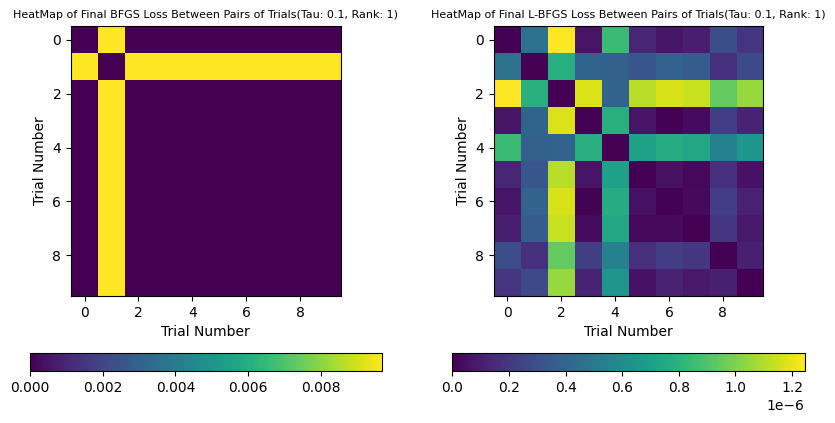

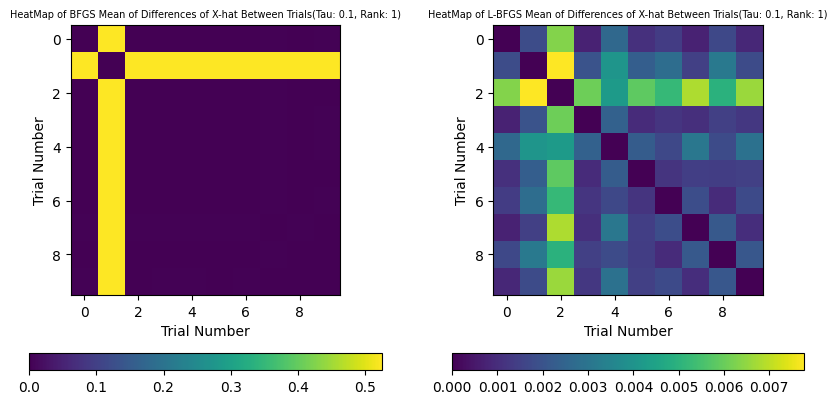

In [133]:
# Second Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_2, all_lbfgs_final_loss_2, all_bfgs_predict_array_2, all_lbfgs_predict_array_2, tau_2, rank_2)

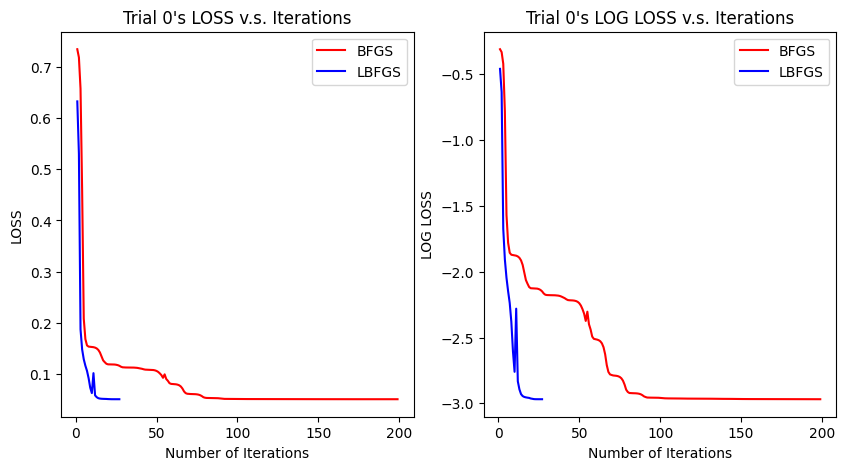

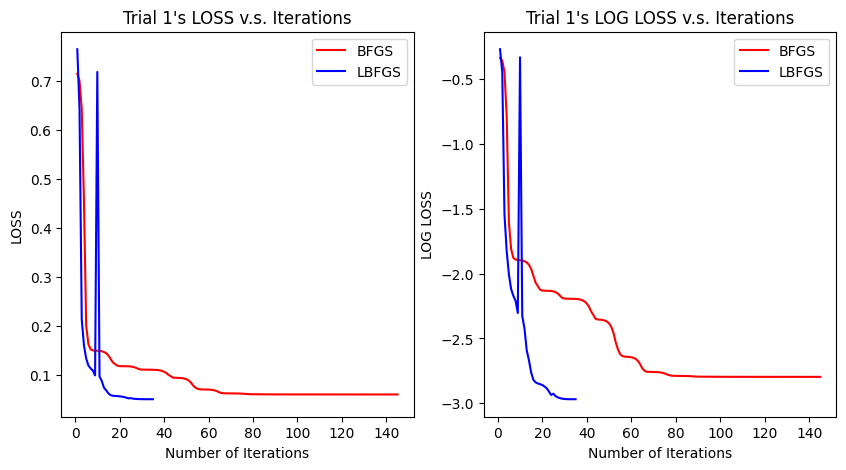

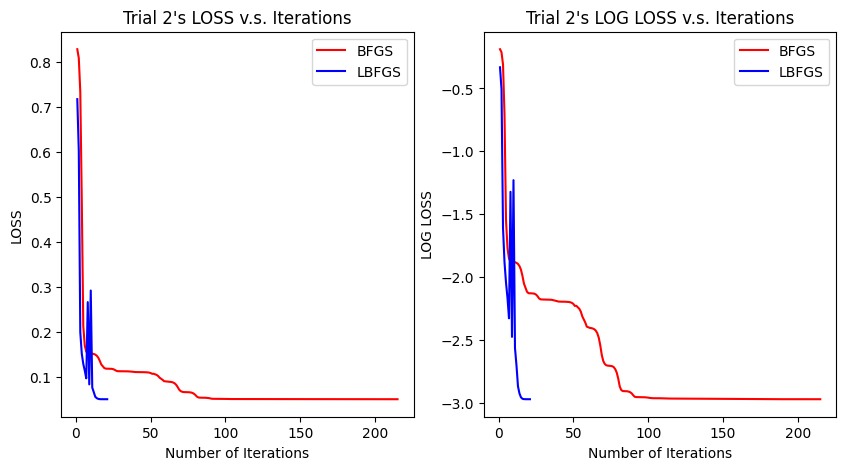

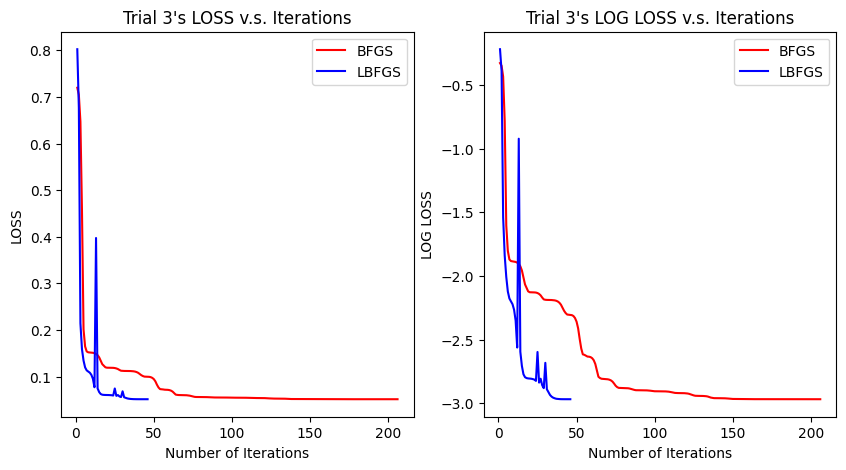

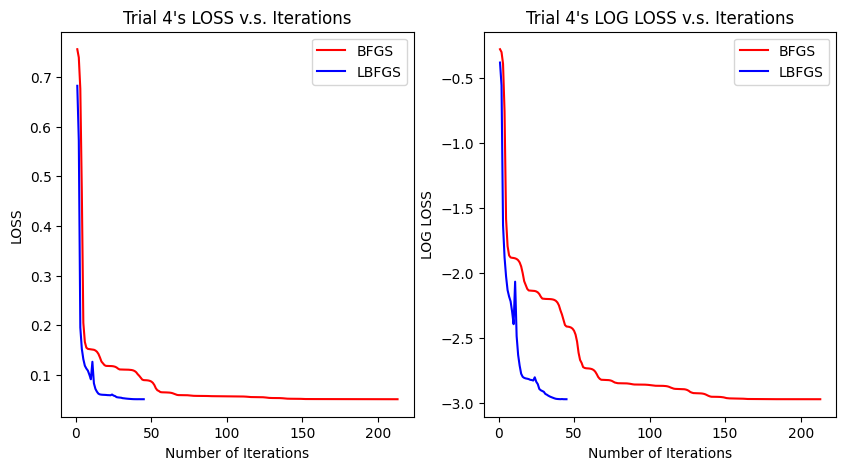

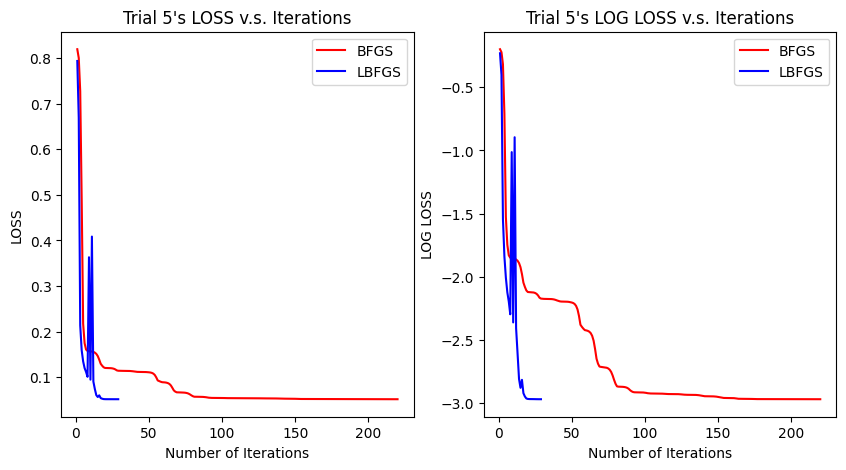

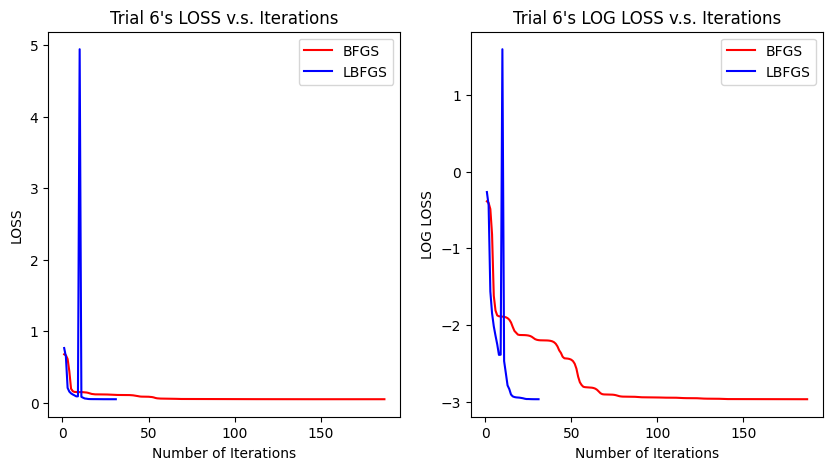

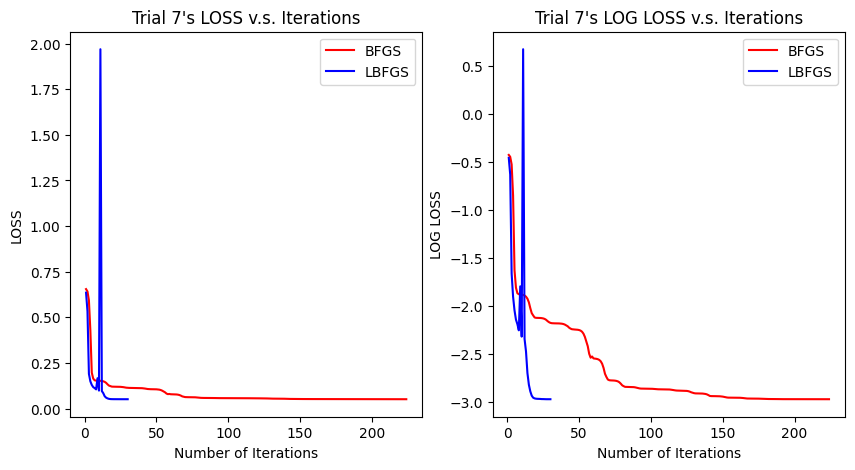

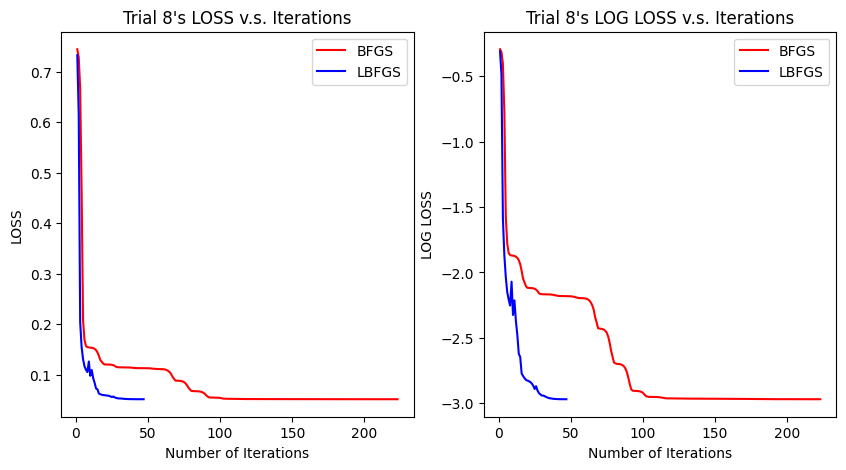

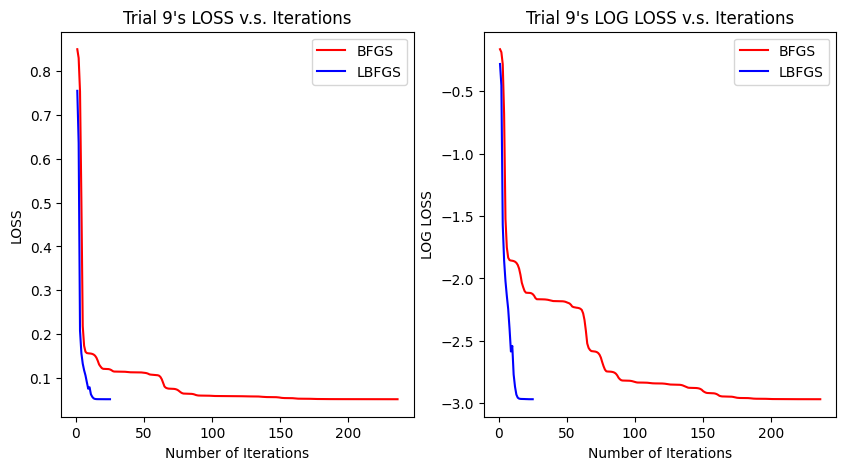

In [134]:
# SETUP 2 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_2[i], all_lbfgs_loss_arrays_2[i])

# Setup 3
Rank 2, Tau 0.3

In [135]:
#-----------------
# Configuration 3:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 2
# Tau: 0.3
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_3 = 2
tau_3 = 0.3
mu_3 = 0
sd_3 = 1
X_config_3, X_normalized_3, X_new_3, true_r_config_3, true_c_config_3, true_u_congfig_3, true_v_config_3, row_mean_3, col_mean_3 = get_normalized_X(m=200, n=200, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=rank_3)
all_bfgs_loss_arrays_3, all_lbfgs_loss_arrays_3, all_bfgs_final_loss_3, all_lbfgs_final_loss_3, all_bfgs_predict_array_3, all_lbfgs_predict_array_3 = run_algorithm_ten_trials_sep_init(X_normalized_3, rank_3, tau_3, row_mean_3, col_mean_3, mu_3, sd_3)

MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  1.2149491064578515e-17
NEW STD:  1.0
BFGS Final Loss: 0.008773649727181495
SETUP 0 BFGS Takes about:  35.10387444496155  (s)
SETUP 0 BFGS Iterations:  127
------------------------------------
L-BFGS-B Final Loss: 0.00877367595215115
SETUP 0 LBFGS Takes about:  0.06898641586303711  (s)
SETUP 0 LBFGS Iterations:  28

BFGS Final Loss: 0.008773742066221984
SETUP 1 BFGS Takes about:  34.624287843704224  (s)
SETUP 

In [136]:
# X_hat = R_1[:, np.newaxis] + C_1 + U_1 @ V_1.T
# X_hat

# X_hat_l = l_R_1[:, np.newaxis] + l_C_1 + l_U_1 @ l_V_1.T
# #print(list(X_hat_l))

# # print(X_hat)
# # print(X_hat_l)
# print(np.sqrt(np.mean((X_hat - X_hat_l)**2)))
# diff = X_hat - X_hat_l
# masked = np.isnan(X_config1)
# X_hat = X_hat[~masked]
# plt.hist(diff.ravel().flat)

# X_hat_l = X_hat_l[~masked]

# plt.plot(X_hat_l.ravel(), lbfgs_new.ravel(), "o")
# plt.plot(X_hat.ravel(), X_new.ravel(), "o")

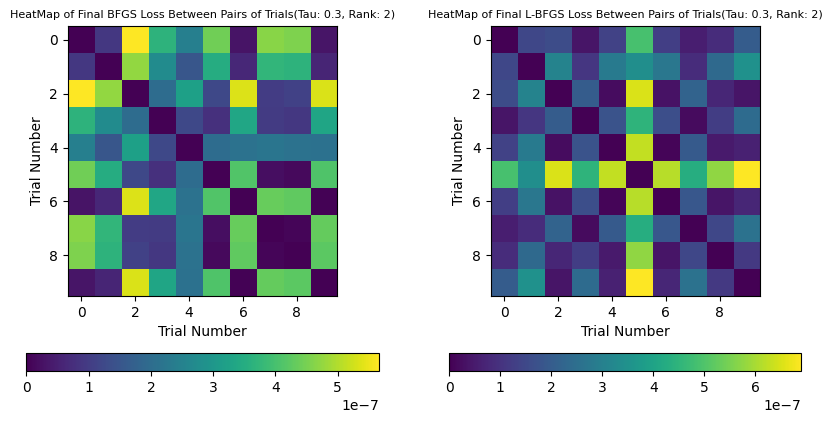

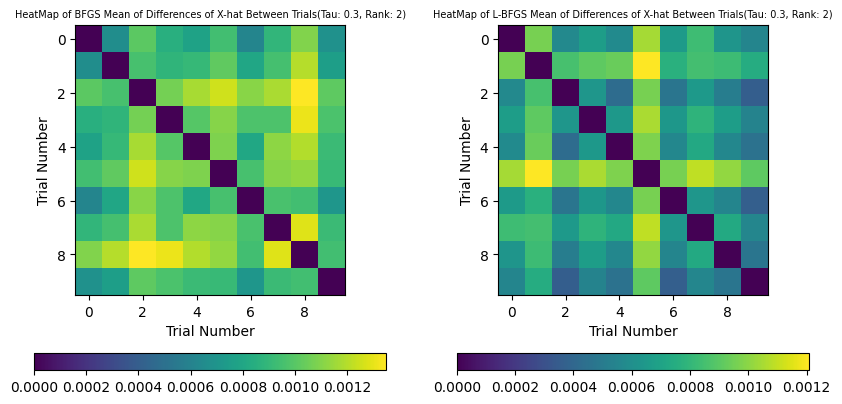

In [137]:
# Third Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_3, all_lbfgs_final_loss_3, all_bfgs_predict_array_3, all_lbfgs_predict_array_3, tau_3, rank_3)

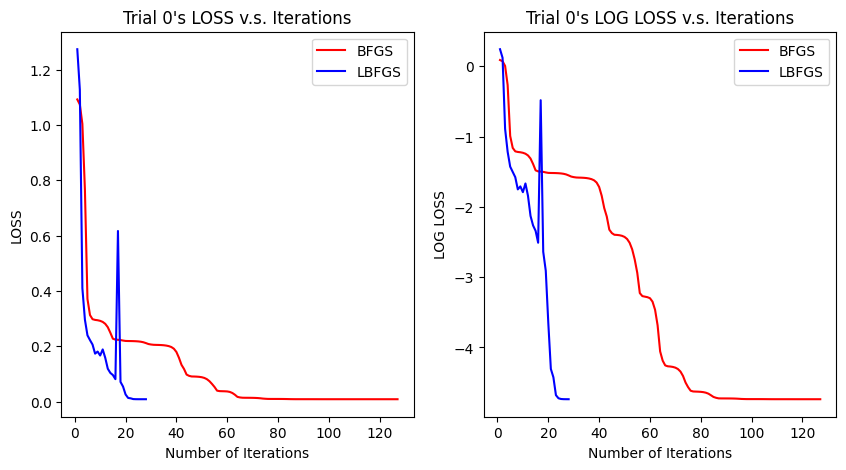

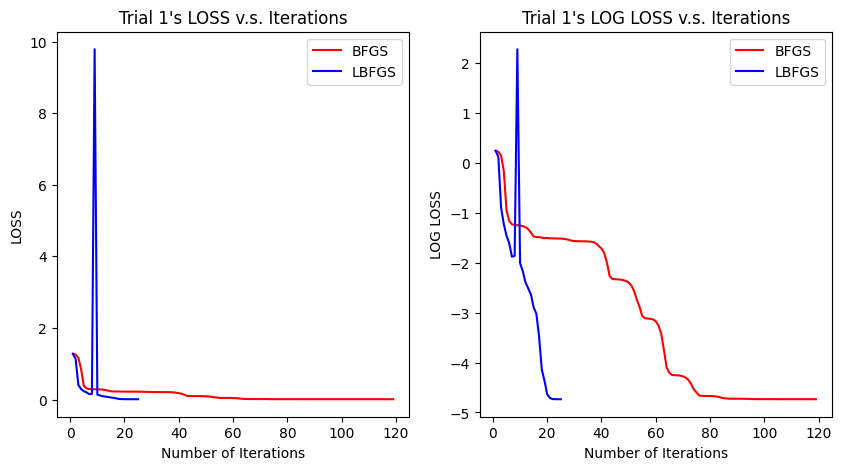

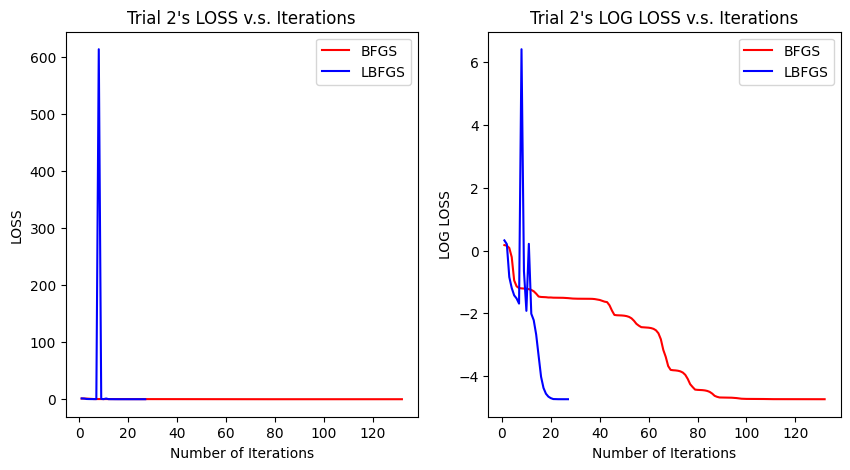

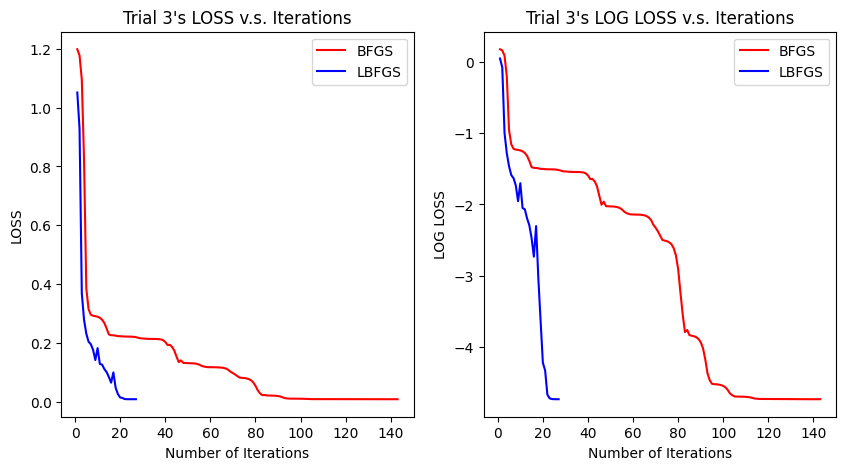

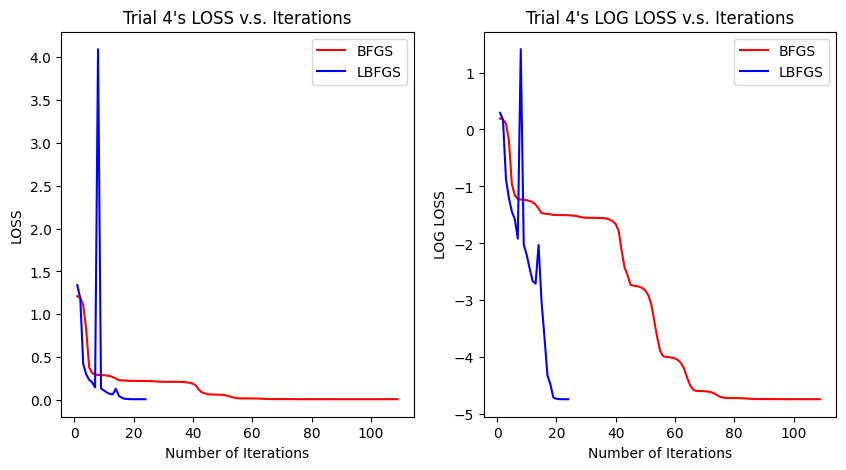

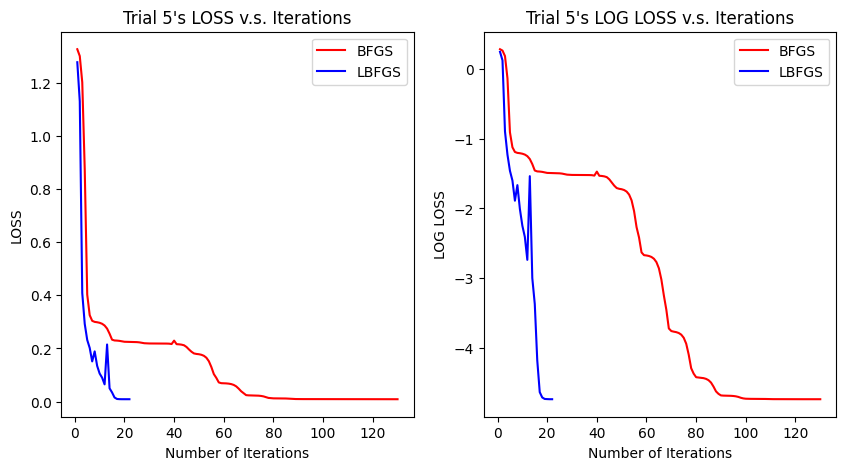

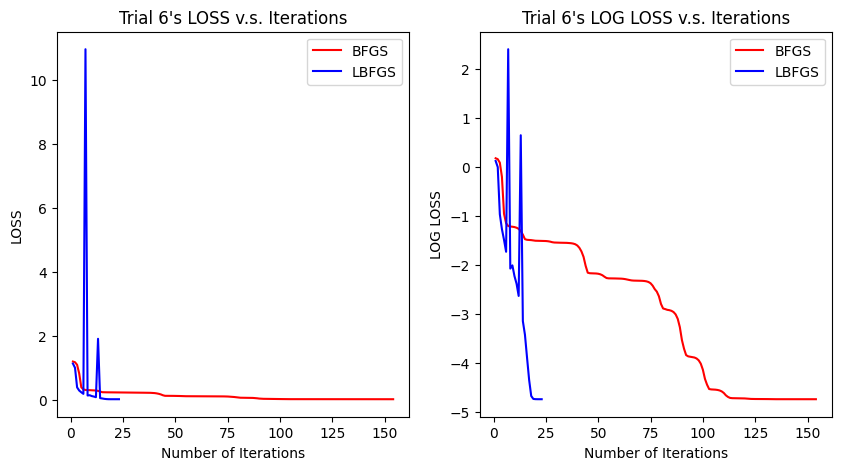

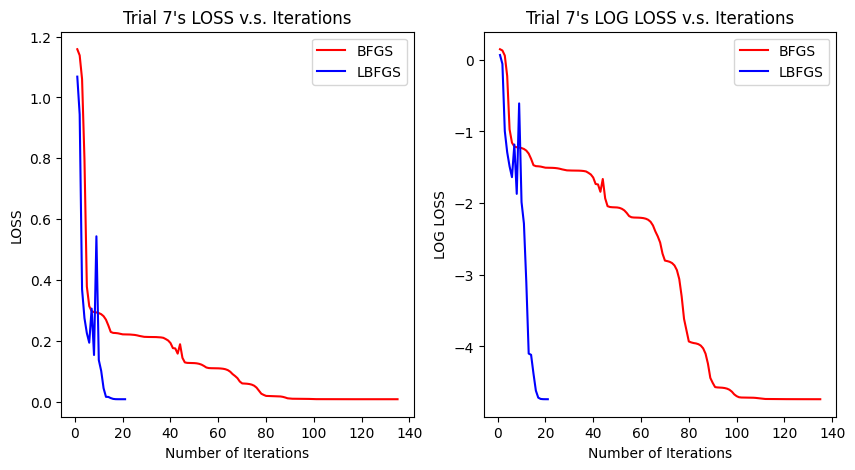

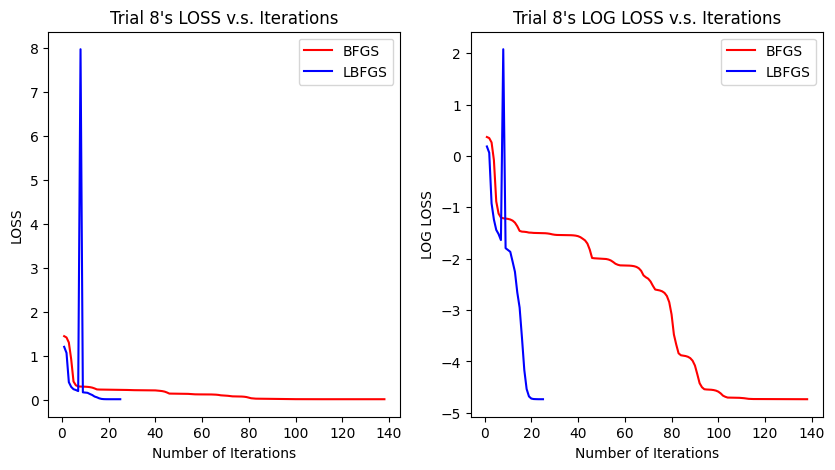

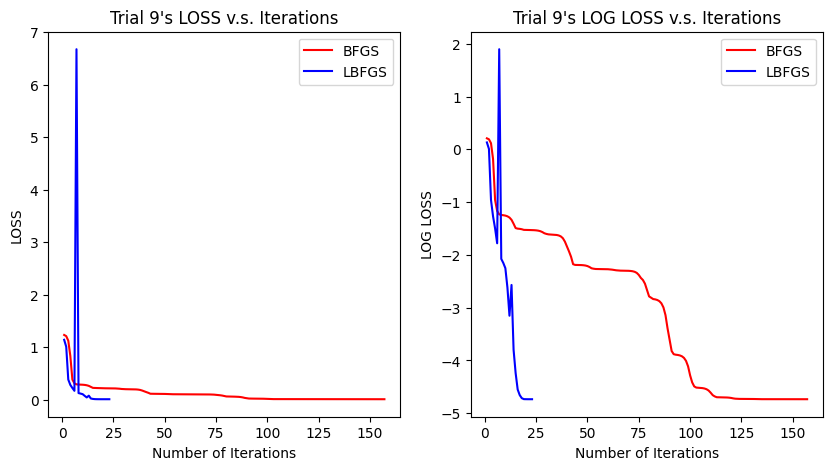

In [138]:
# SETUP 3 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_3[i], all_lbfgs_loss_arrays_3[i])

# Setup 4
Rank 2, Tau 0.5

In [139]:
#-----------------
# Configuration 4:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 2
# Tau: 0.5
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_4 = 2
tau_4 = 0.5
mu_4 = 0
sd_4 = 1
X_config_4, X_normalized_4, X_new_4, true_r_config_4, true_c_config_4, true_u_congfig_4, true_v_config_4, row_mean_4, col_mean_4 = get_normalized_X(m=200, n=200, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=rank_4)
all_bfgs_loss_arrays_4, all_lbfgs_loss_arrays_4, all_bfgs_final_loss_4, all_lbfgs_final_loss_4, all_bfgs_predict_array_4, all_lbfgs_predict_array_4 = run_algorithm_ten_trials_sep_init(X_normalized_4, rank_4, tau_4, row_mean_4, col_mean_4, mu_4, sd_4)

MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  1.2149491064578515e-17
NEW STD:  1.0
BFGS Final Loss: 0.009818656170100486
SETUP 0 BFGS Takes about:  30.532941818237305  (s)
SETUP 0 BFGS Iterations:  114
------------------------------------
L-BFGS-B Final Loss: 0.009819053606678684
SETUP 0 LBFGS Takes about:  0.0690464973449707  (s)
SETUP 0 LBFGS Iterations:  27

BFGS Final Loss: 0.009818854307221786
SETUP 1 BFGS Takes about:  29.565882444381714  (s)
SETUP

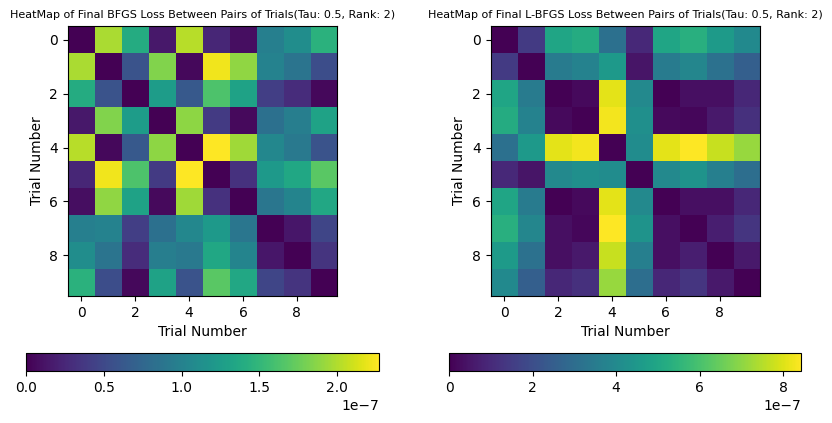

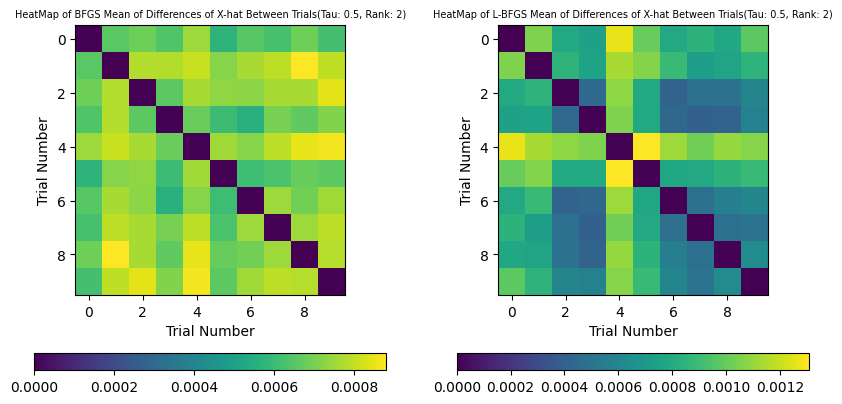

In [140]:
# Fourth Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_4, all_lbfgs_final_loss_4, all_bfgs_predict_array_4, all_lbfgs_predict_array_4, tau_4, rank_4)

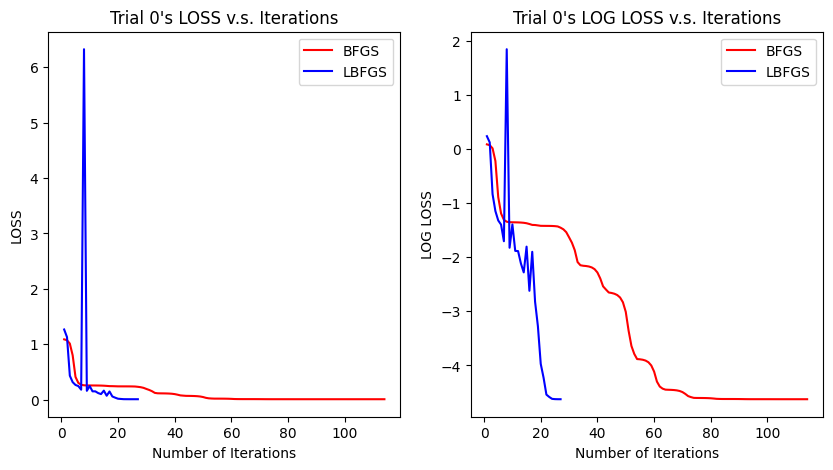

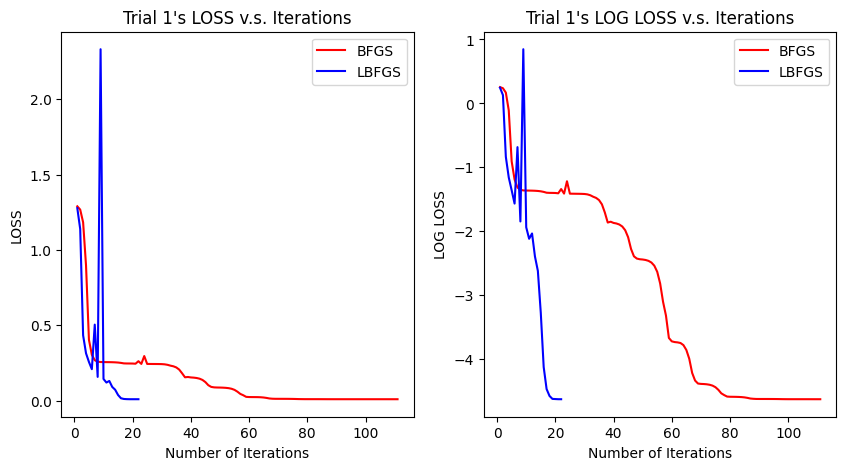

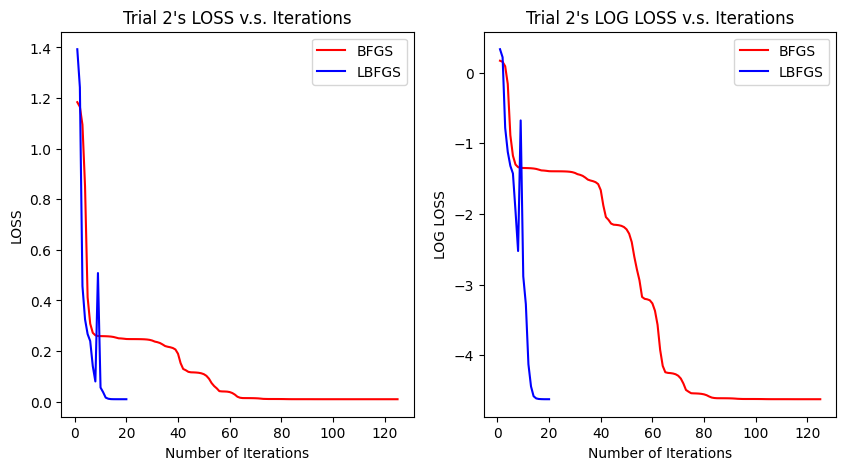

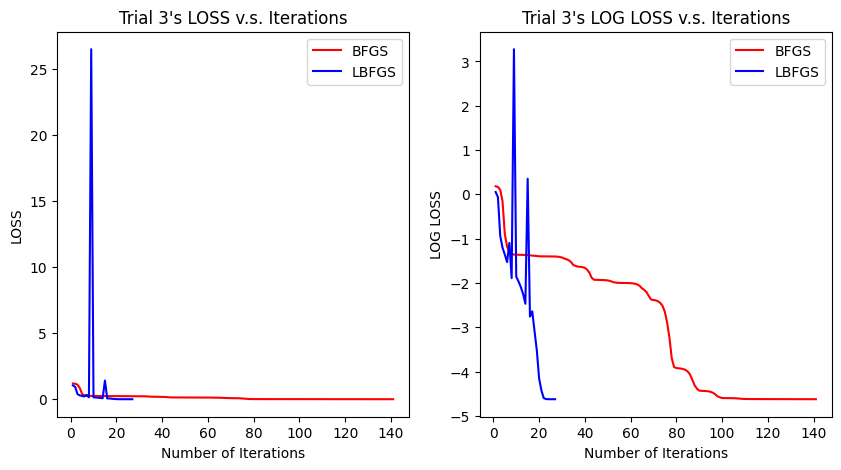

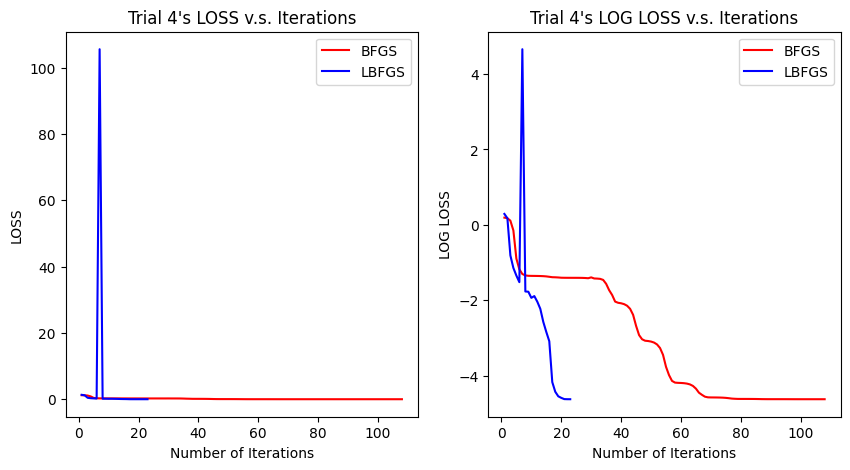

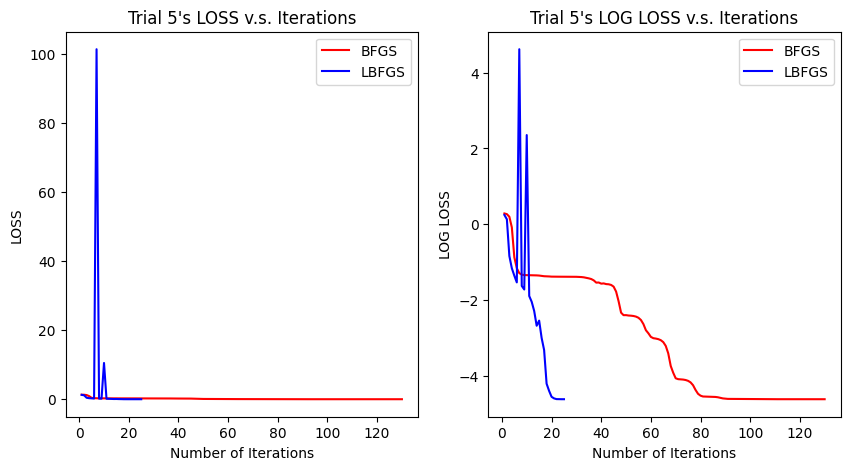

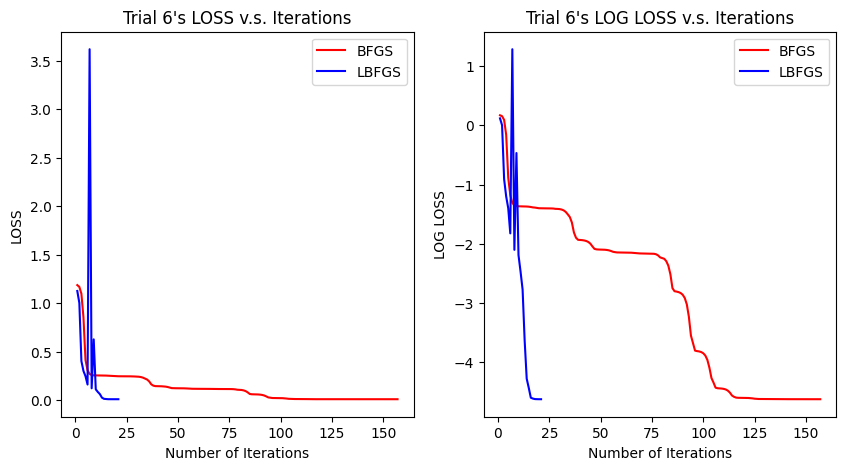

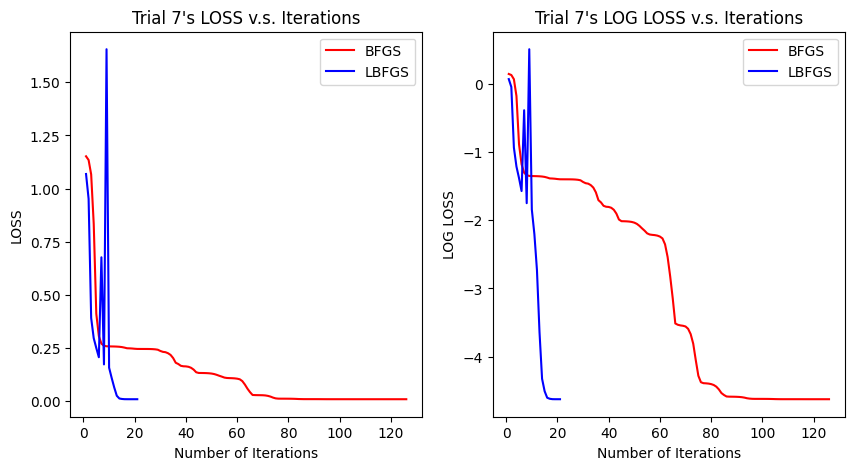

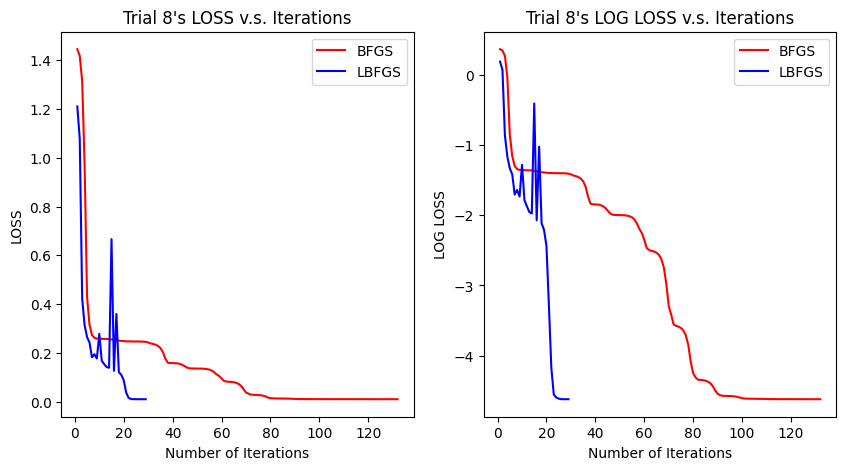

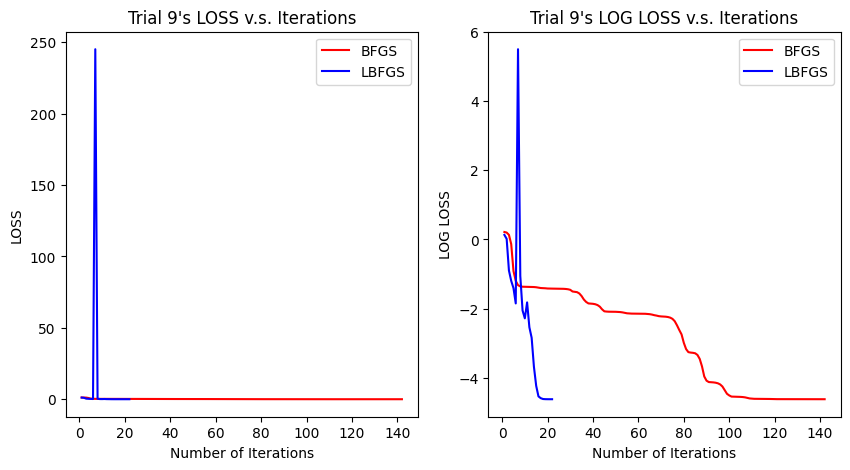

In [141]:
# SETUP 4 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_4[i], all_lbfgs_loss_arrays_4[i])

# Setup 5
Rank 2, Tau 0.7

In [142]:
#-----------------
# Configuration 5:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 2
# Tau: 0.7
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_5 = 2
tau_5 = 0.7
mu_5 = 0
sd_5 = 1
X_config_5, X_normalized_5, X_new_5, true_r_config_5, true_c_config_5, true_u_congfig_5, true_v_config_5, row_mean_5, col_mean_5 = get_normalized_X(m=200, n=200, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=rank_5)
all_bfgs_loss_arrays_5, all_lbfgs_loss_arrays_5, all_bfgs_final_loss_5, all_lbfgs_final_loss_5, all_bfgs_predict_array_5, all_lbfgs_predict_array_5 = run_algorithm_ten_trials_sep_init(X_normalized_5, rank_5, tau_5, row_mean_5, col_mean_5, mu_5, sd_5)

MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  1.2149491064578515e-17
NEW STD:  1.0
BFGS Final Loss: 0.008728721308935187
SETUP 0 BFGS Takes about:  34.03260517120361  (s)
SETUP 0 BFGS Iterations:  117
------------------------------------
L-BFGS-B Final Loss: 0.00872849754763659
SETUP 0 LBFGS Takes about:  0.06685900688171387  (s)
SETUP 0 LBFGS Iterations:  26

BFGS Final Loss: 0.008728822056676579
SETUP 1 BFGS Takes about:  31.67067837715149  (s)
SETUP 1

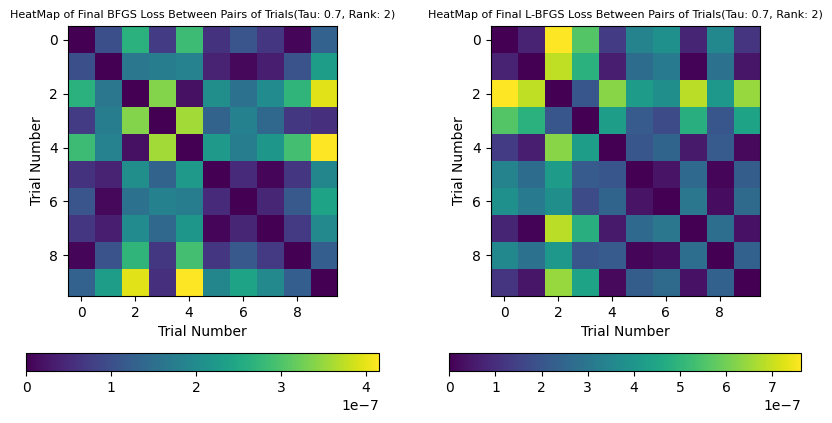

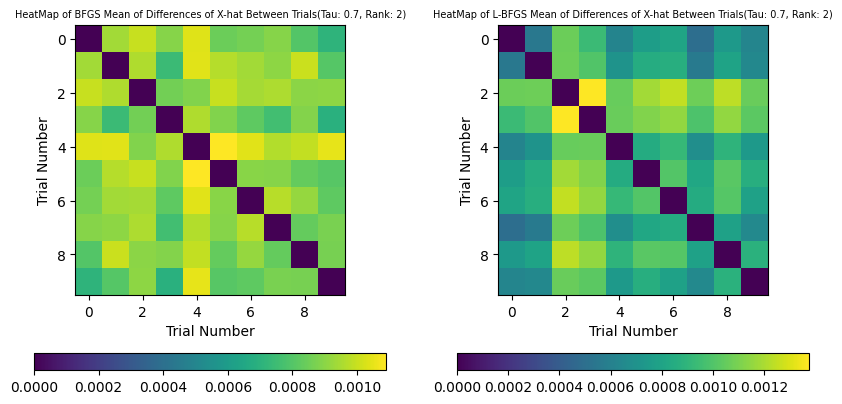

In [143]:
# 5 Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_5, all_lbfgs_final_loss_5, all_bfgs_predict_array_5, all_lbfgs_predict_array_5, tau_5, rank_5)

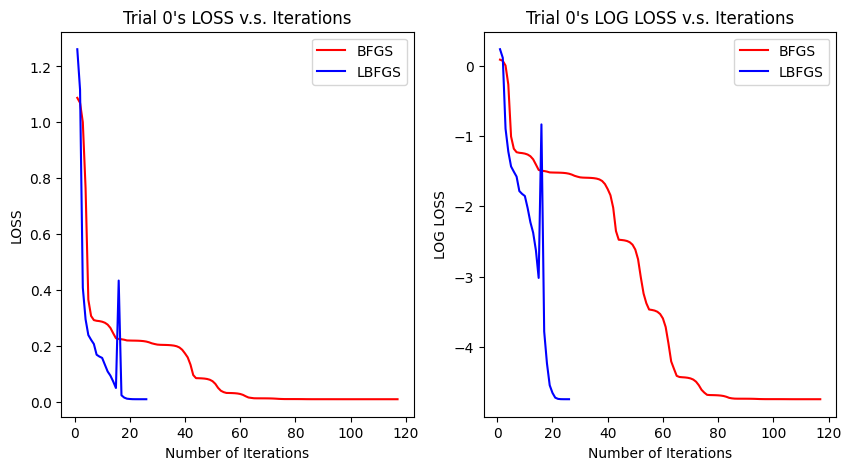

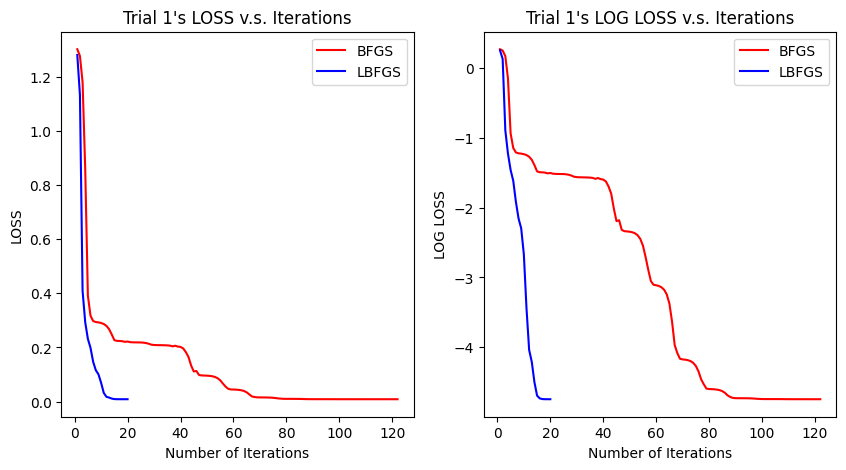

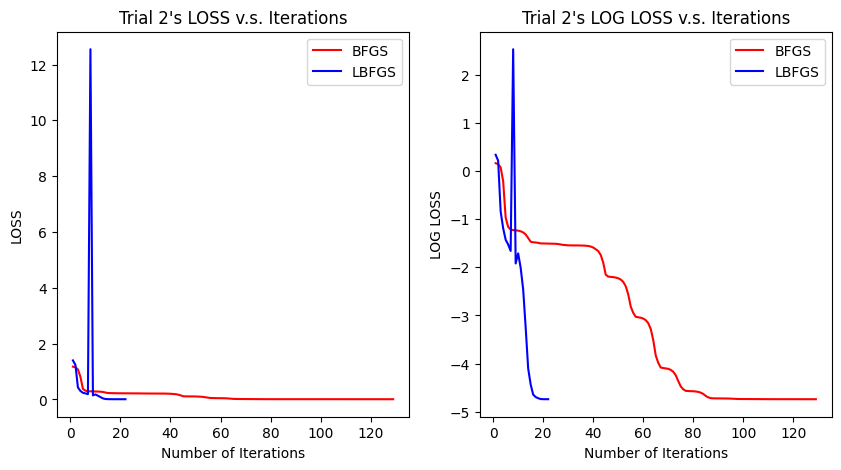

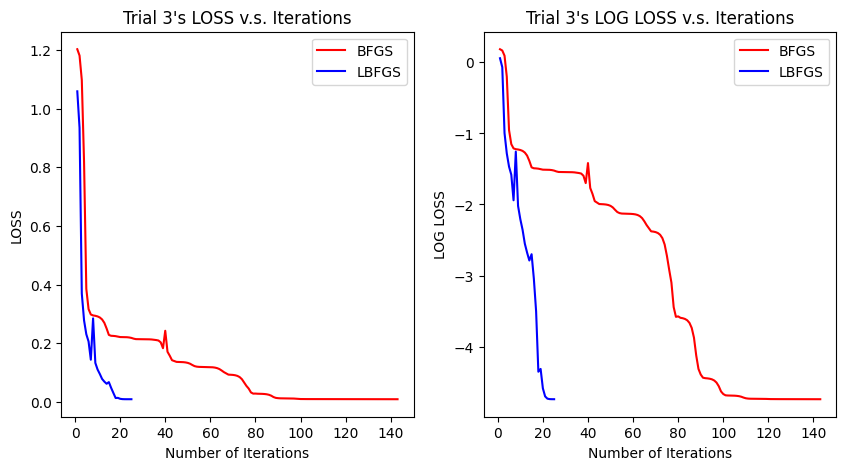

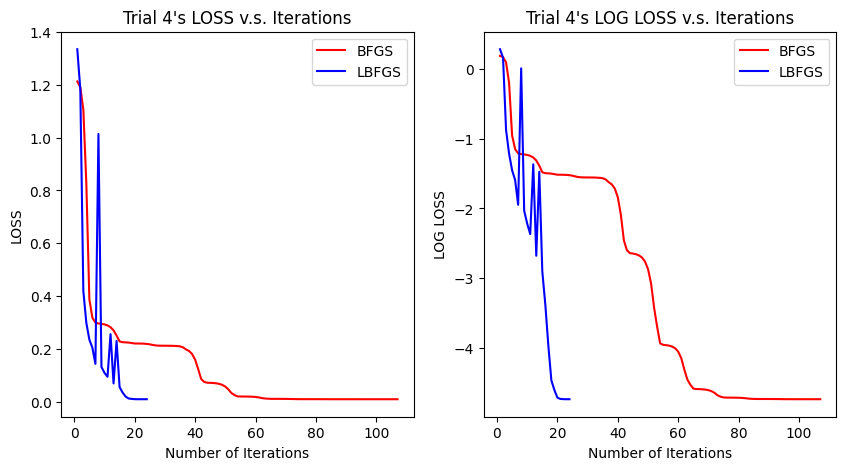

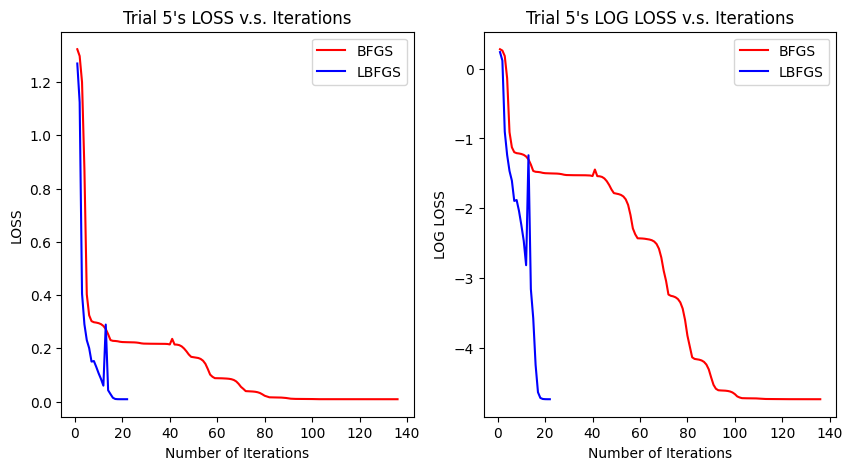

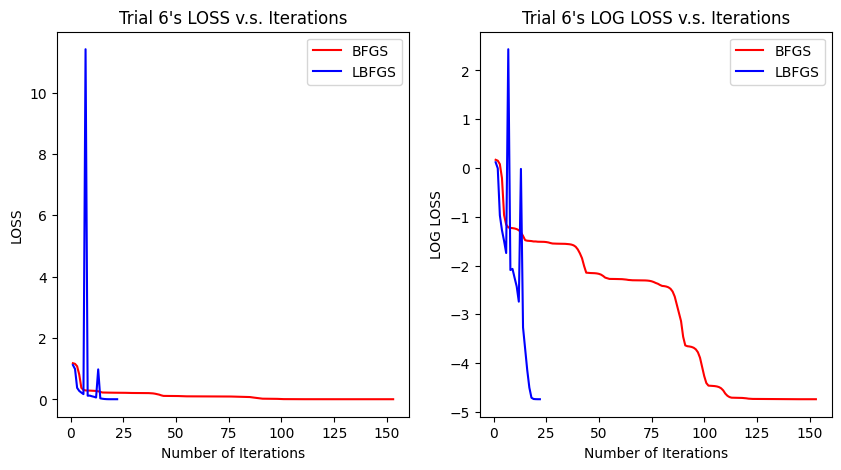

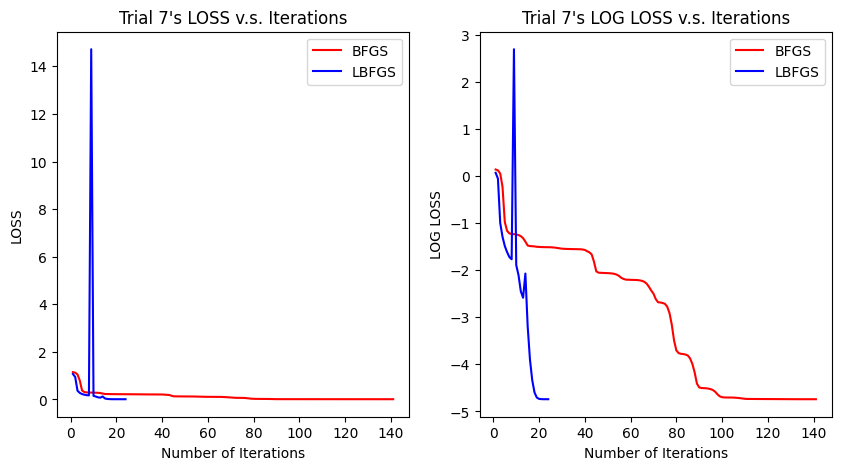

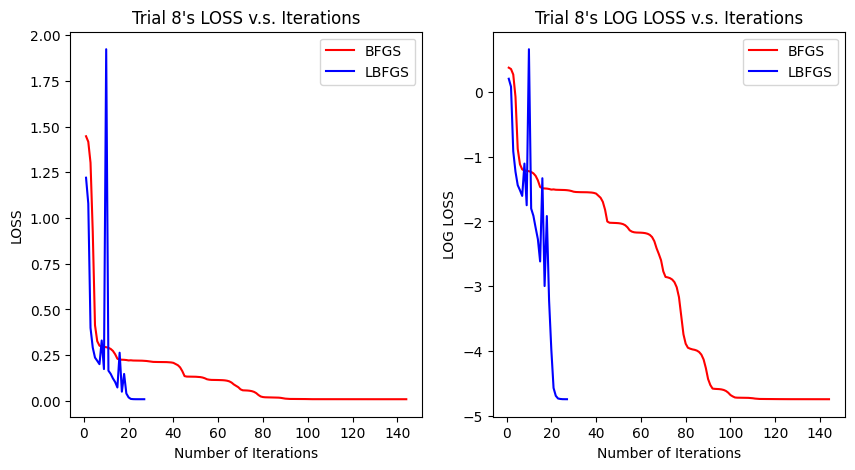

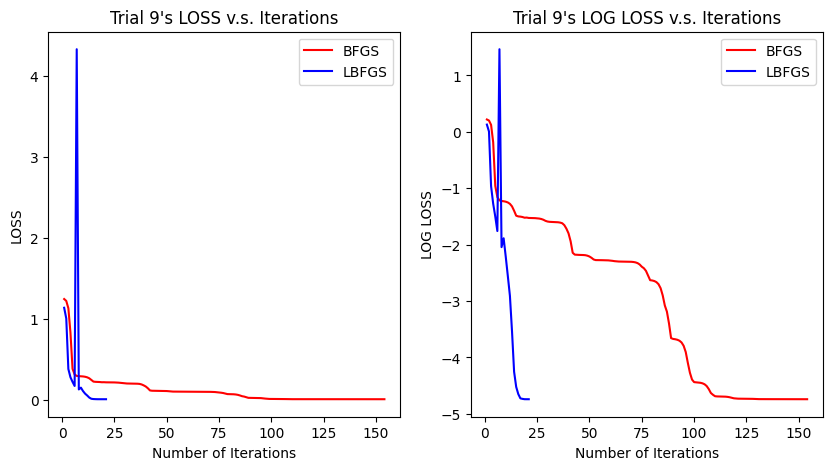

In [144]:
# SETUP 5 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_5[i], all_lbfgs_loss_arrays_5[i])

# Setup 6
Rank 2, Tau 0.9


In [145]:
#-----------------
# Configuration 6:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 2
# Tau: 0.9
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_6 = 2
tau_6 = 0.9
mu_6 = 0
sd_6 = 1
X_config_6, X_normalized_6, X_new_6, true_r_config_6, true_c_config_6, true_u_congfig_6, true_v_config_6, row_mean_6, col_mean_6 = get_normalized_X(m=200, n=200, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=rank_6)
all_bfgs_loss_arrays_6, all_lbfgs_loss_arrays_6, all_bfgs_final_loss_6, all_lbfgs_final_loss_6, all_bfgs_predict_array_6, all_lbfgs_predict_array_6 = run_algorithm_ten_trials_sep_init(X_normalized_6, rank_6, tau_6, row_mean_6, col_mean_6, mu_6, sd_6)

MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  1.2149491064578515e-17
NEW STD:  1.0
BFGS Final Loss: 0.004860719881596709
SETUP 0 BFGS Takes about:  39.360992193222046  (s)
SETUP 0 BFGS Iterations:  137
------------------------------------
L-BFGS-B Final Loss: 0.004859001359815171
SETUP 0 LBFGS Takes about:  0.08688998222351074  (s)
SETUP 0 LBFGS Iterations:  34

BFGS Final Loss: 0.004859173469408982
SETUP 1 BFGS Takes about:  42.232505798339844  (s)
SETU

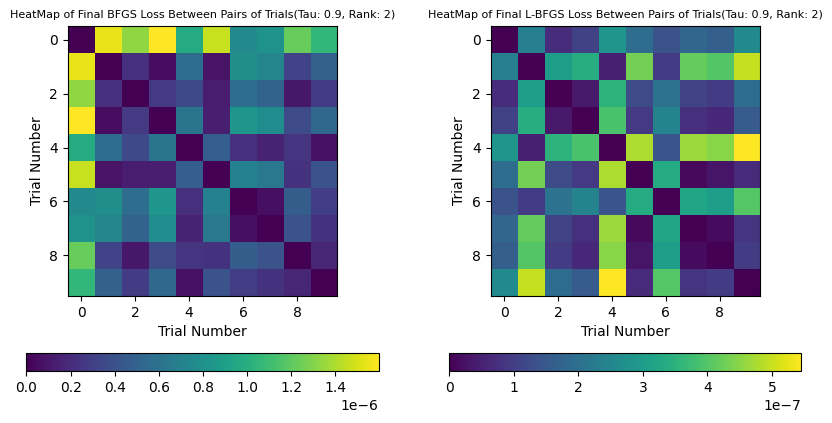

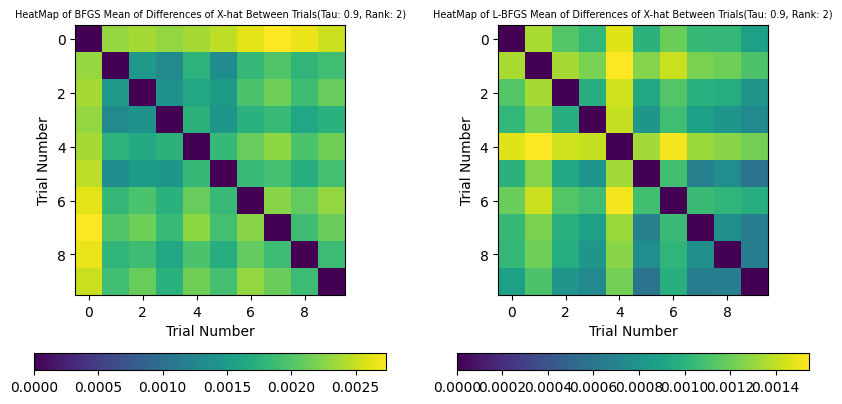

In [146]:
# 6 Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_6, all_lbfgs_final_loss_6, all_bfgs_predict_array_6, all_lbfgs_predict_array_6, tau_6, rank_6)

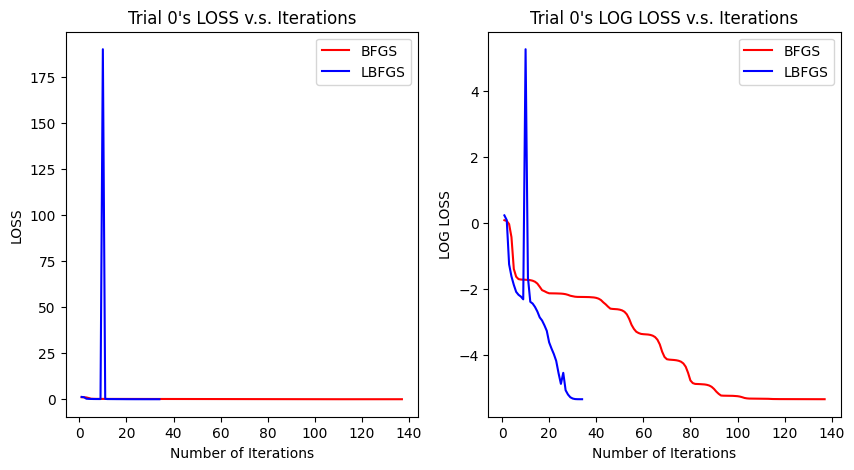

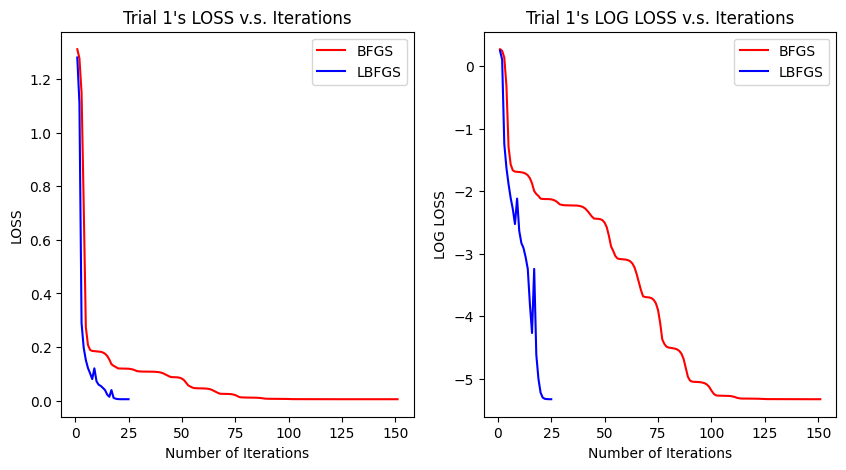

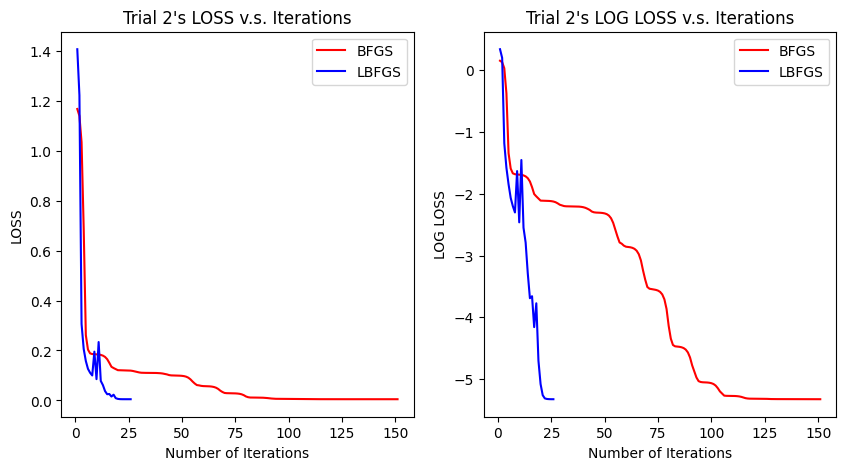

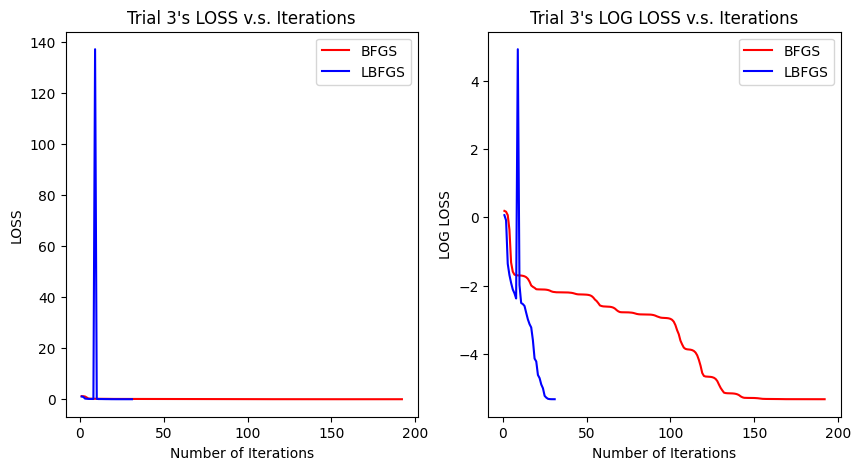

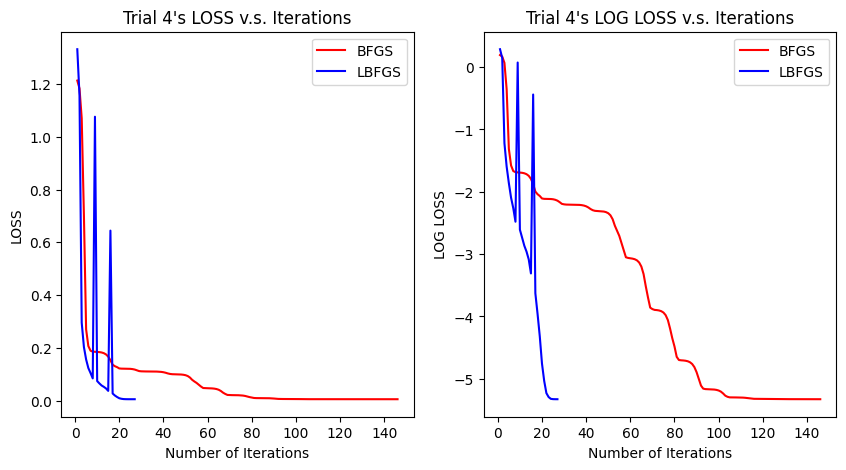

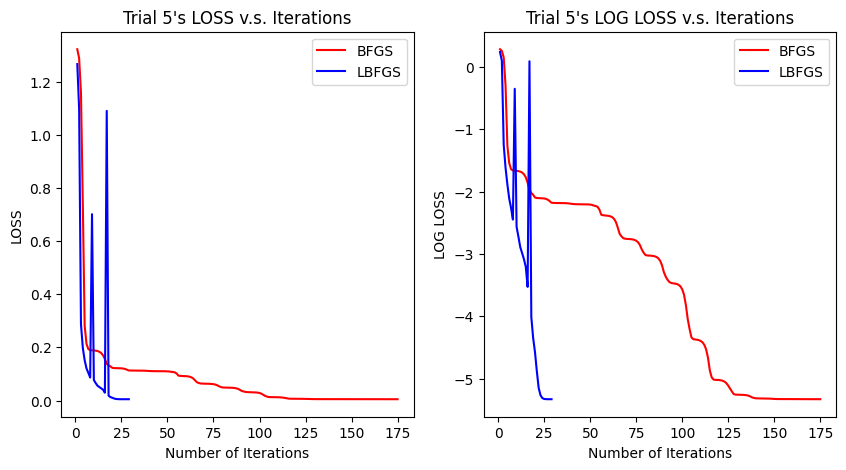

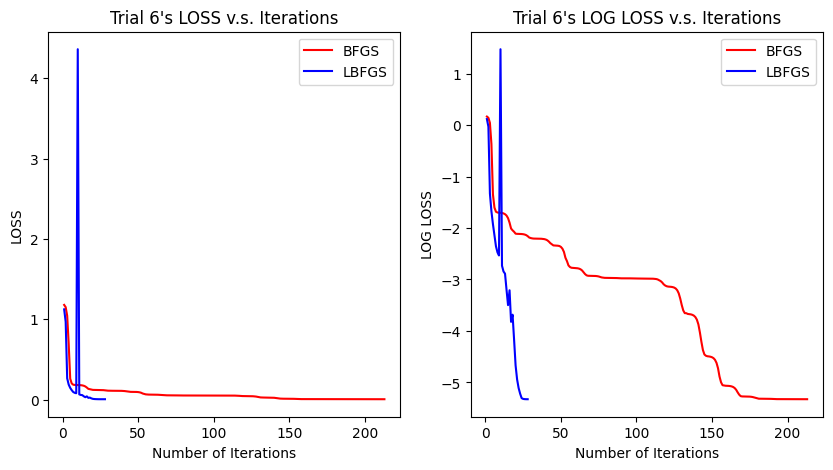

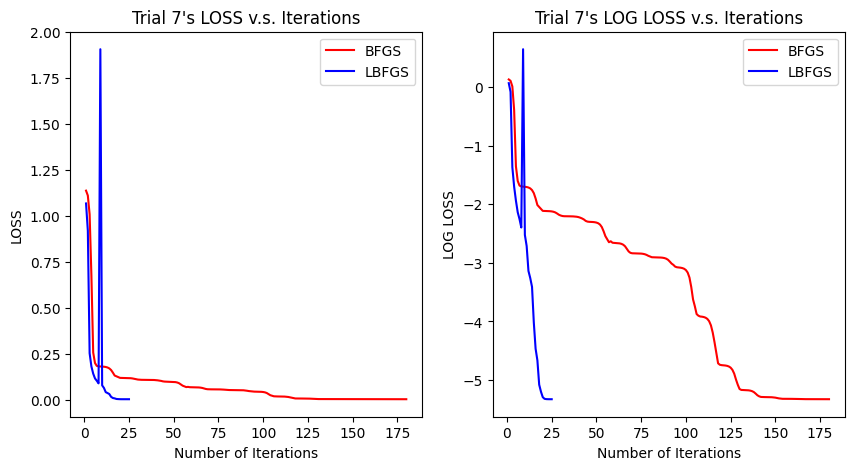

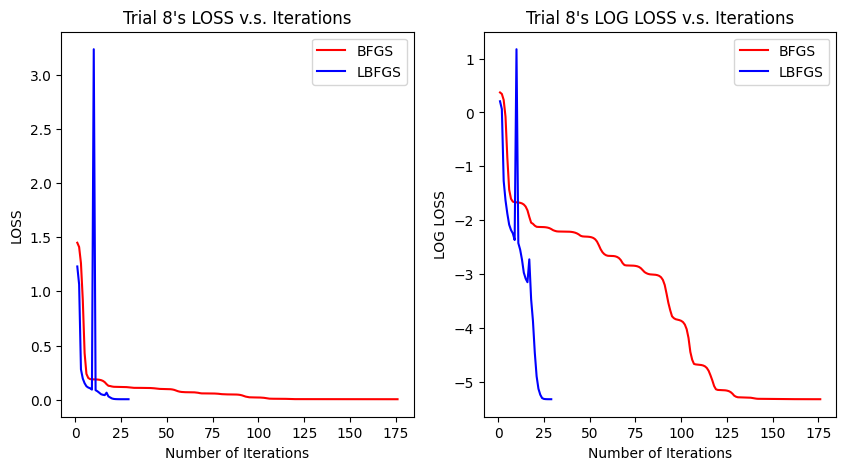

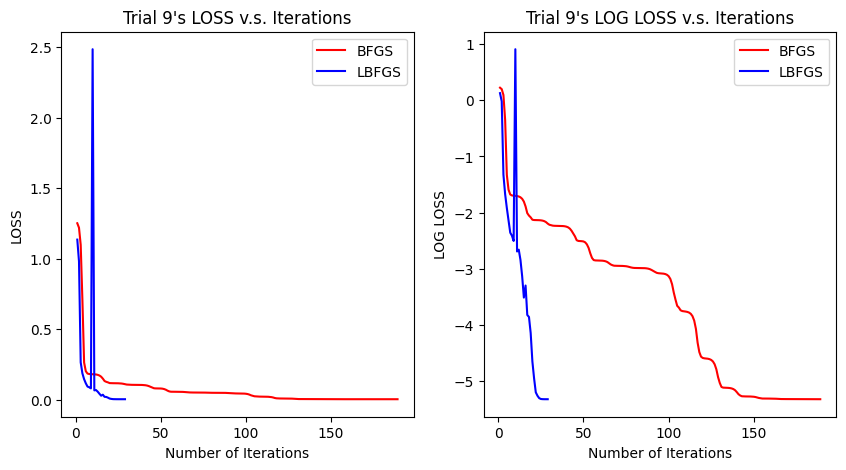

In [147]:
# SETUP 6 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_6[i], all_lbfgs_loss_arrays_6[i])

# Setup 7
Rank 3


In [148]:
#-----------------
# Configuration 7:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 3
# Tau: 0.9
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_7 = 3
tau_7 = 0.9
mu_7 = 0
sd_7 = 1
X_config_7, X_normalized_7, X_new_7, true_r_config_7, true_c_config_7, true_u_congfig_7, true_v_config_7, row_mean_7, col_mean_7 = get_normalized_X(m=200, n=200, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=rank_7)
all_bfgs_loss_arrays_7, all_lbfgs_loss_arrays_7, all_bfgs_final_loss_7, all_lbfgs_final_loss_7, all_bfgs_predict_array_7, all_lbfgs_predict_array_7 = run_algorithm_ten_trials_sep_init(X_normalized_7, rank_7, tau_7, row_mean_7, col_mean_7, mu_7, sd_7)

MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  1.2149491064578515e-17
NEW STD:  1.0
BFGS Final Loss: 0.004778928047905368
SETUP 0 BFGS Takes about:  136.01379442214966  (s)
SETUP 0 BFGS Iterations:  209
------------------------------------
L-BFGS-B Final Loss: 0.004806726069890497
SETUP 0 LBFGS Takes about:  0.08269953727722168  (s)
SETUP 0 LBFGS Iterations:  27

BFGS Final Loss: 0.004801662656205545
SETUP 1 BFGS Takes about:  120.6183750629425  (s)
SETUP

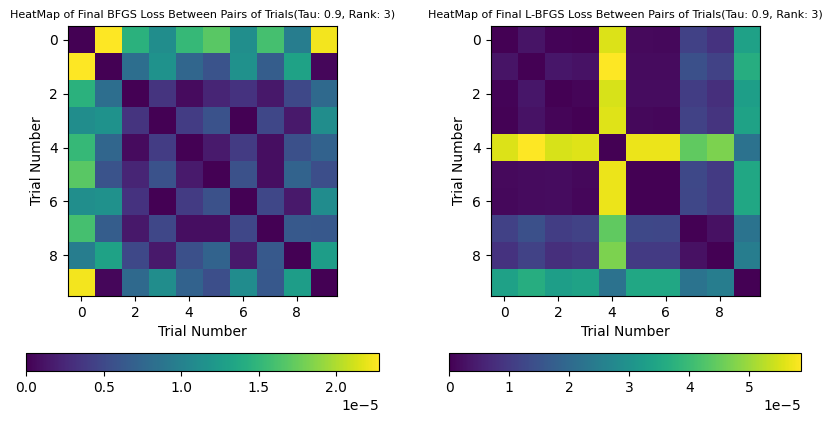

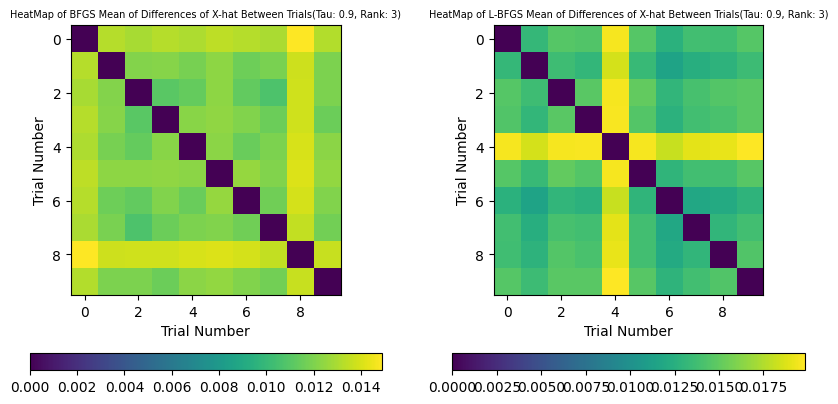

In [149]:
# 7 Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_7, all_lbfgs_final_loss_7, all_bfgs_predict_array_7, all_lbfgs_predict_array_7, tau_7, rank_7)

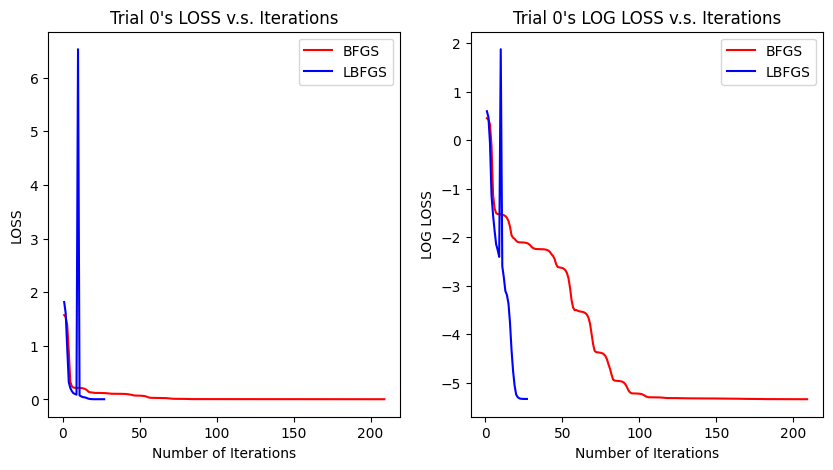

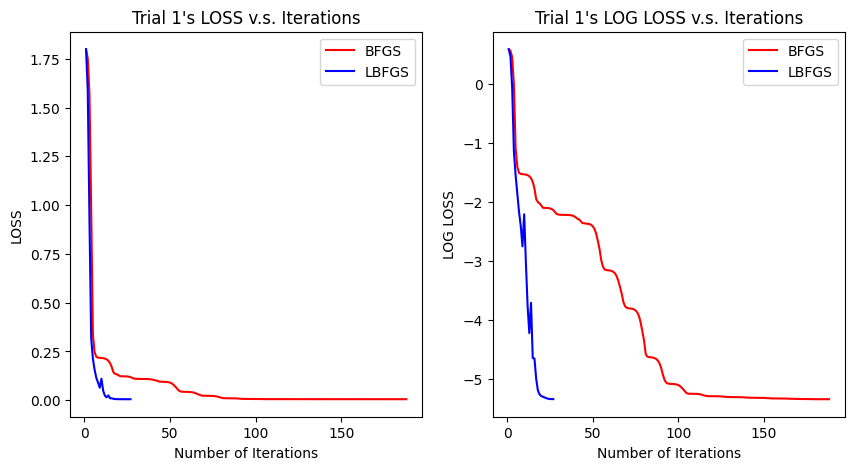

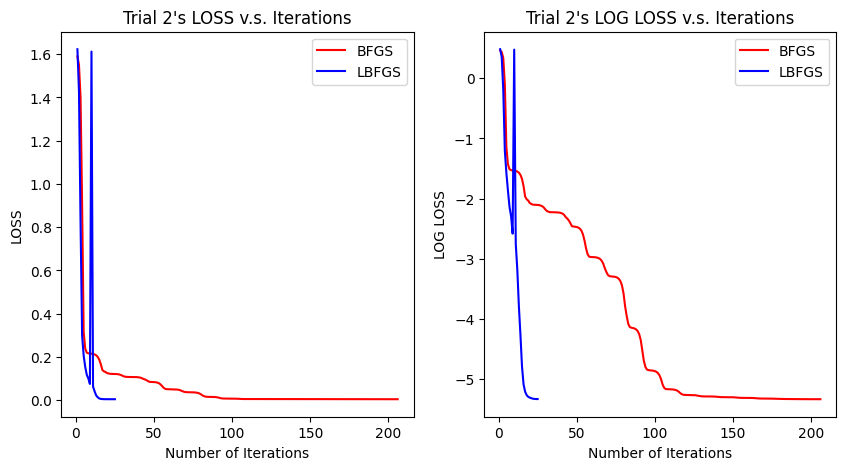

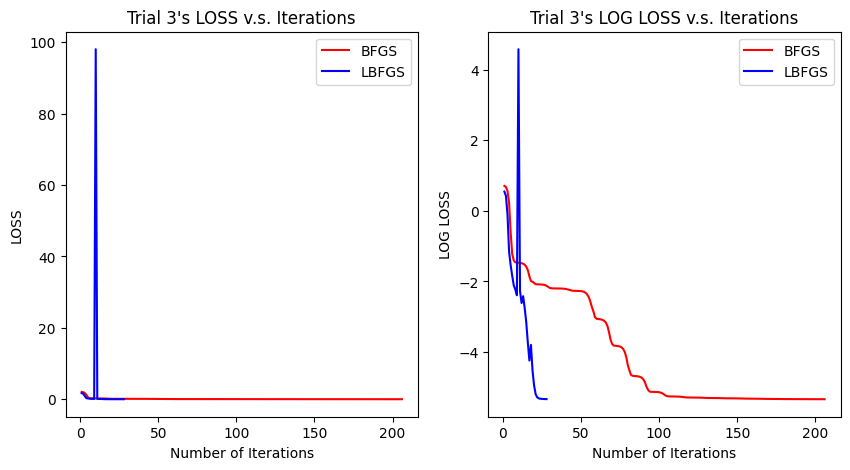

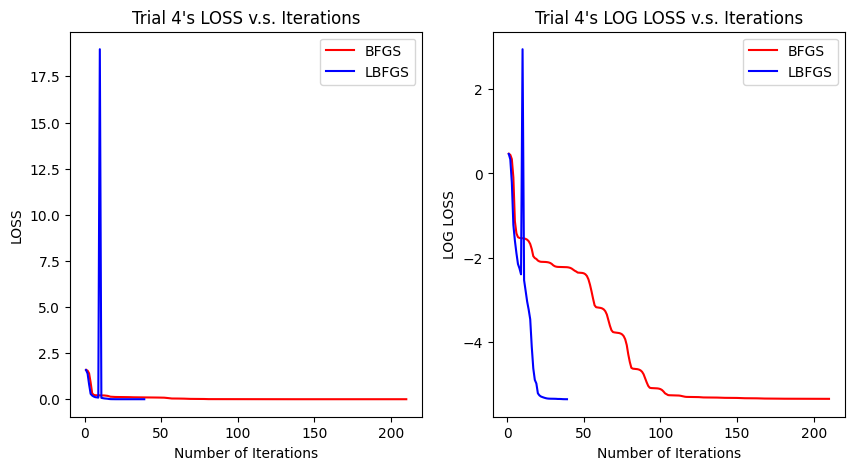

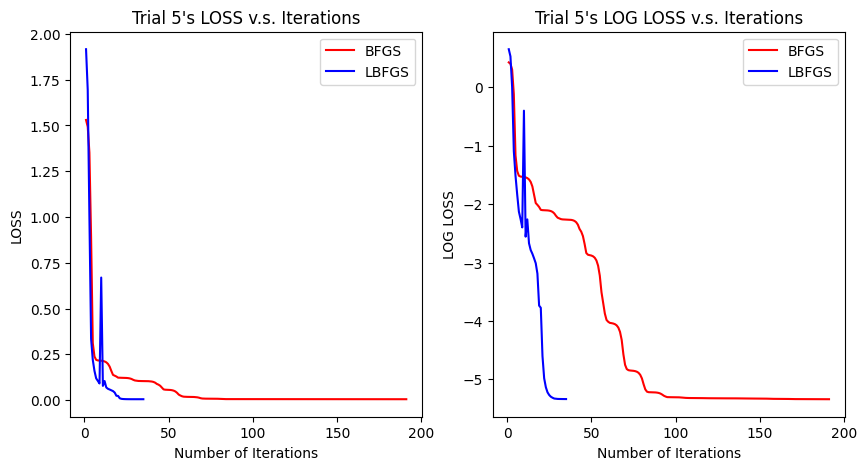

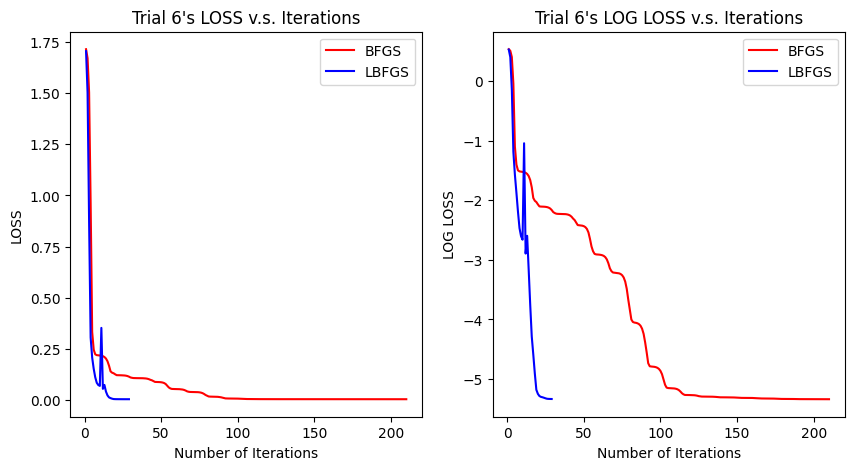

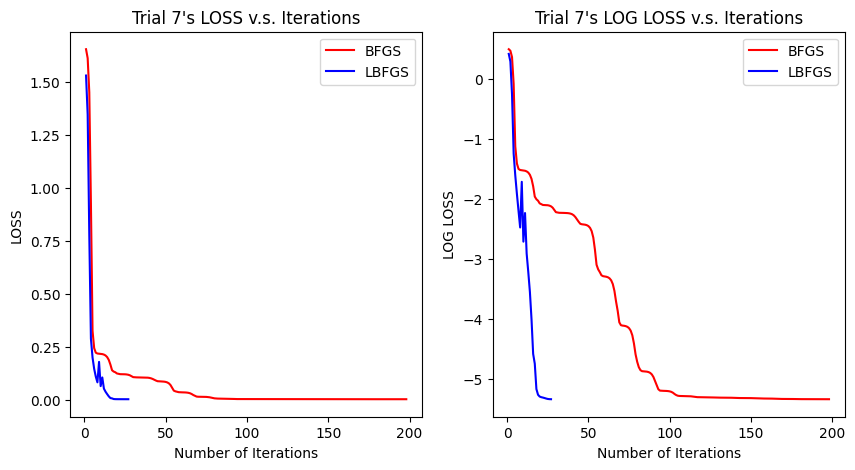

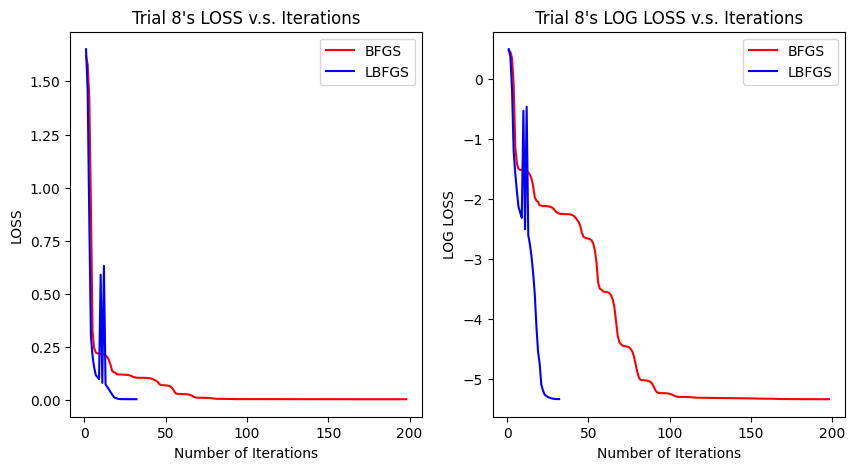

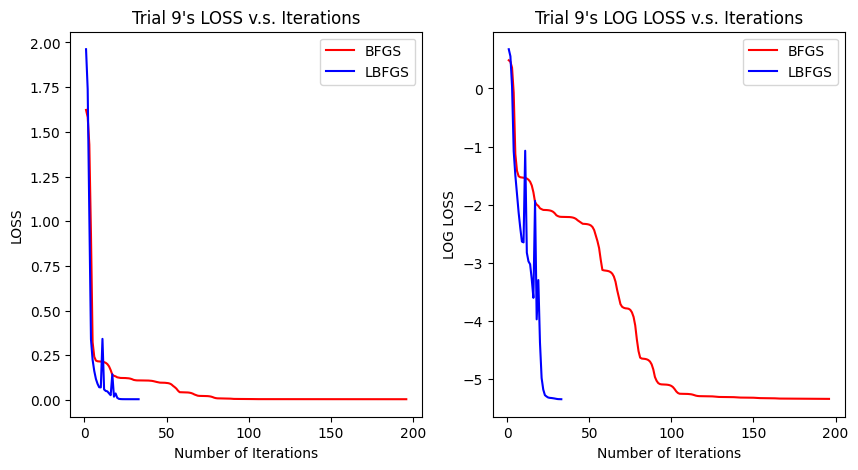

In [150]:
# SETUP 7 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_7[i], all_lbfgs_loss_arrays_7[i])

# Setup 8
Rank 4


In [151]:
#-----------------
# Configuration 8:

# Matrix Size: 200 * 200
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 4
# Tau: 0.9
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_8 = 4
tau_8 = 0.9
mu_8 = 0
sd_8 = 1
X_config_8, X_normalized_8, X_new_8, true_r_config_8, true_c_config_8, true_u_congfig_8, true_v_config_8, row_mean_8, col_mean_8 = get_normalized_X(m=200, n=200, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=rank_8)
all_bfgs_loss_arrays_8, all_lbfgs_loss_arrays_8, all_bfgs_final_loss_8, all_lbfgs_final_loss_8, all_bfgs_predict_array_8, all_lbfgs_predict_array_8 = run_algorithm_ten_trials_sep_init(X_normalized_8, rank_8, tau_8, row_mean_8, col_mean_8, mu_8, sd_8)

MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  1.2149491064578515e-17
NEW STD:  1.0
BFGS Final Loss: 0.004732149182236922
SETUP 0 BFGS Takes about:  221.21160364151  (s)
SETUP 0 BFGS Iterations:  185
------------------------------------
L-BFGS-B Final Loss: 0.004763901262764251
SETUP 0 LBFGS Takes about:  0.07543349266052246  (s)
SETUP 0 LBFGS Iterations:  26

BFGS Final Loss: 0.0047512987909054906
SETUP 1 BFGS Takes about:  224.07678627967834  (s)
SETUP 

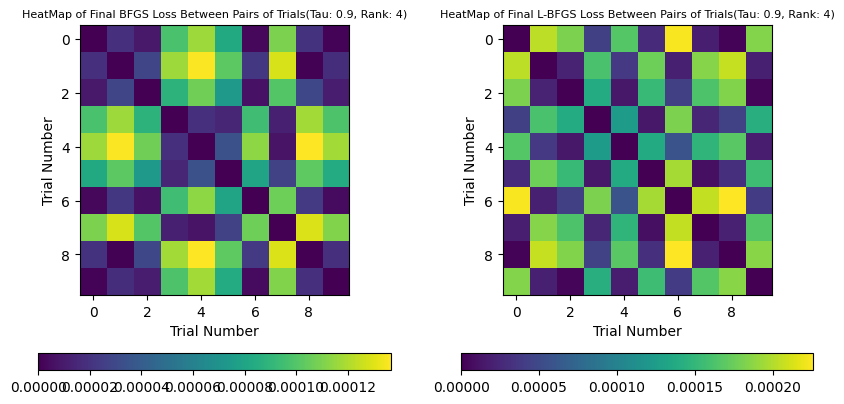

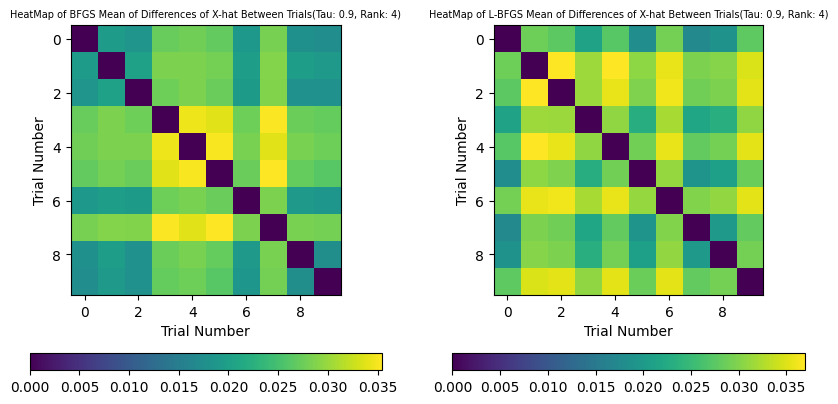

In [152]:
# 8 Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_8, all_lbfgs_final_loss_8, all_bfgs_predict_array_8, all_lbfgs_predict_array_8, tau_8, rank_8)

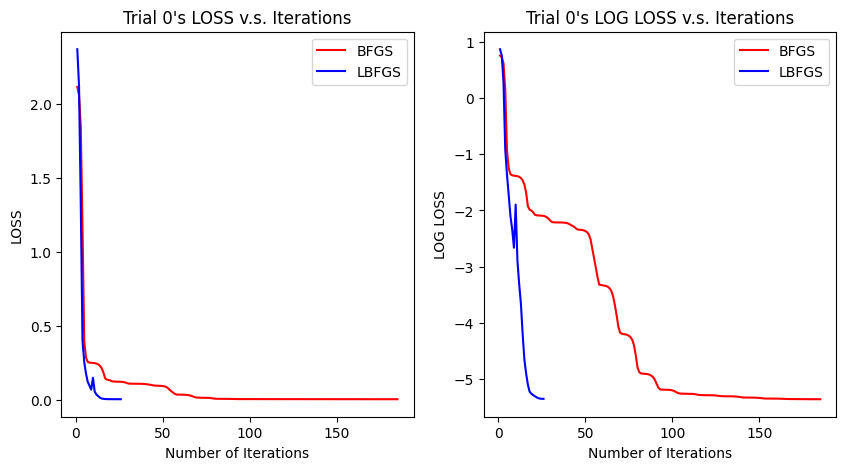

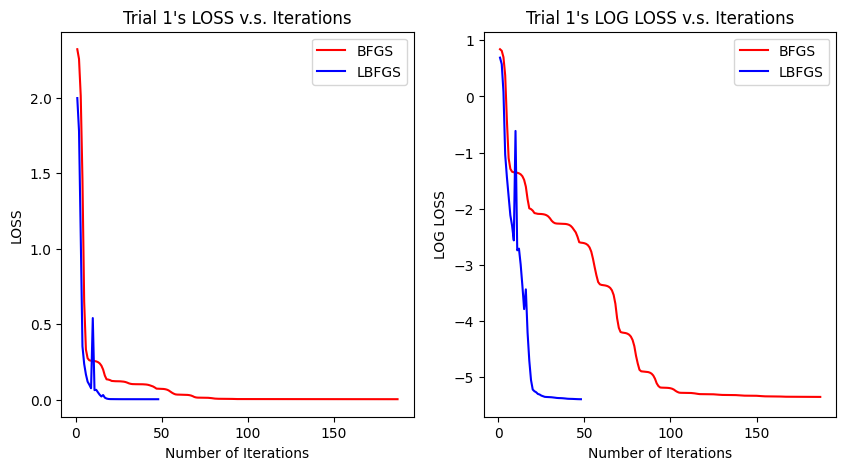

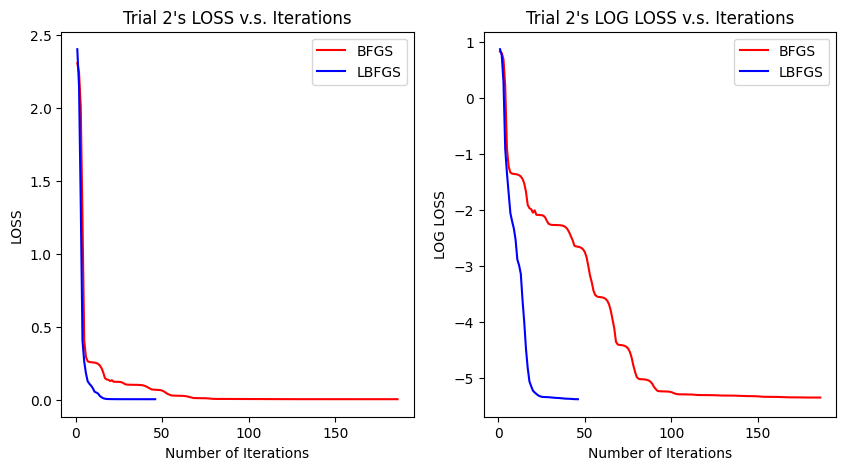

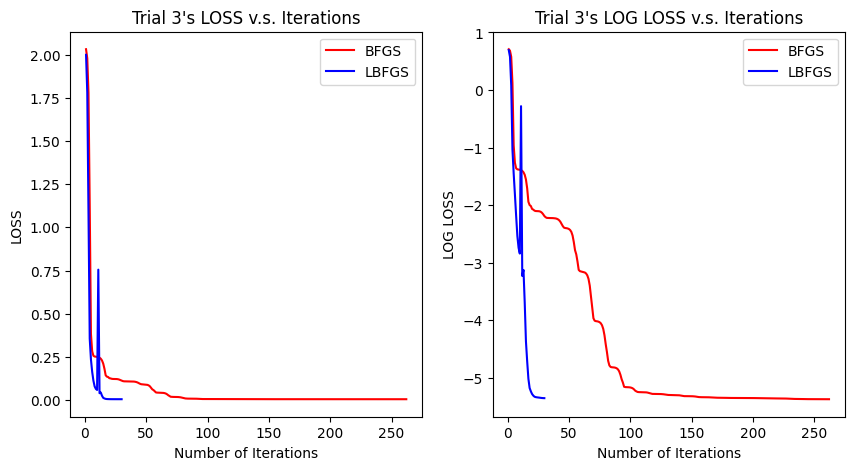

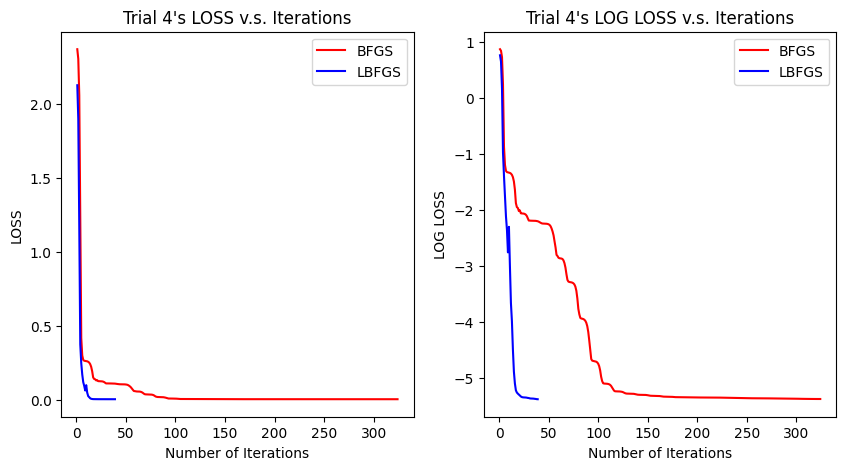

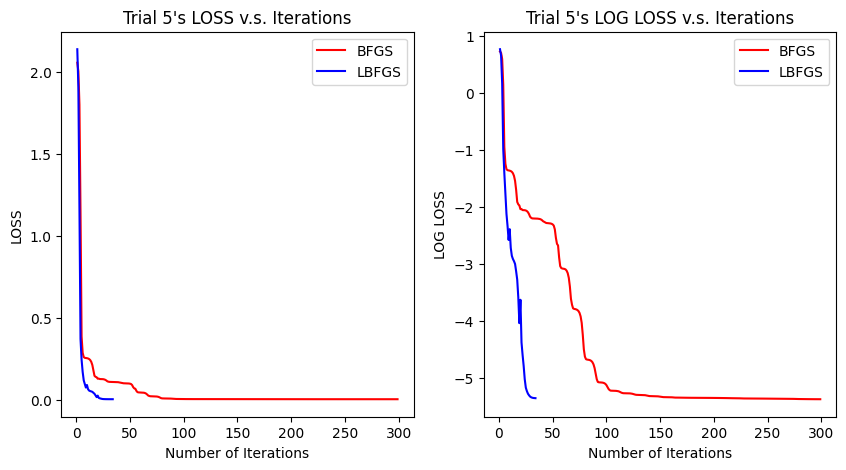

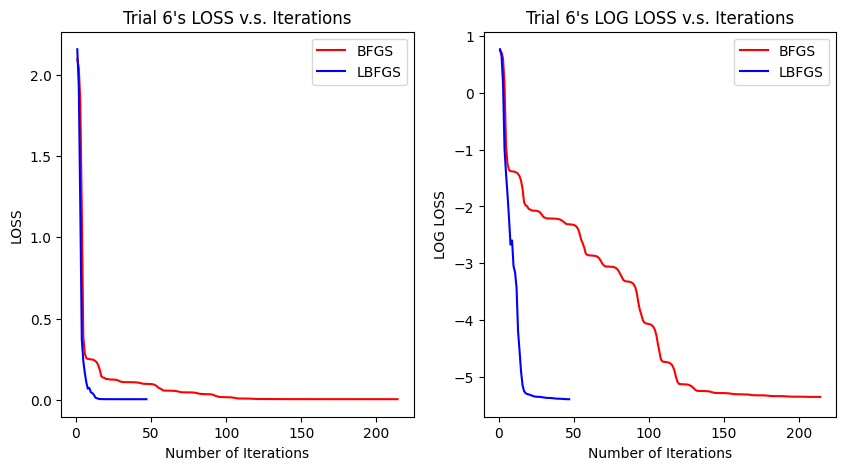

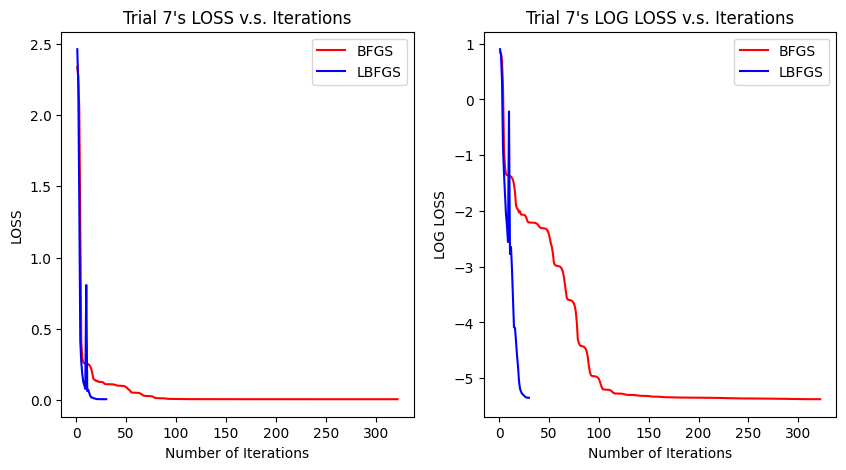

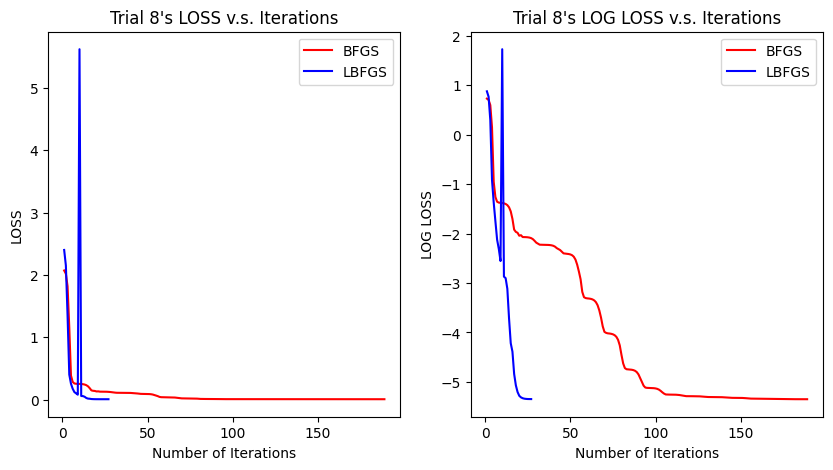

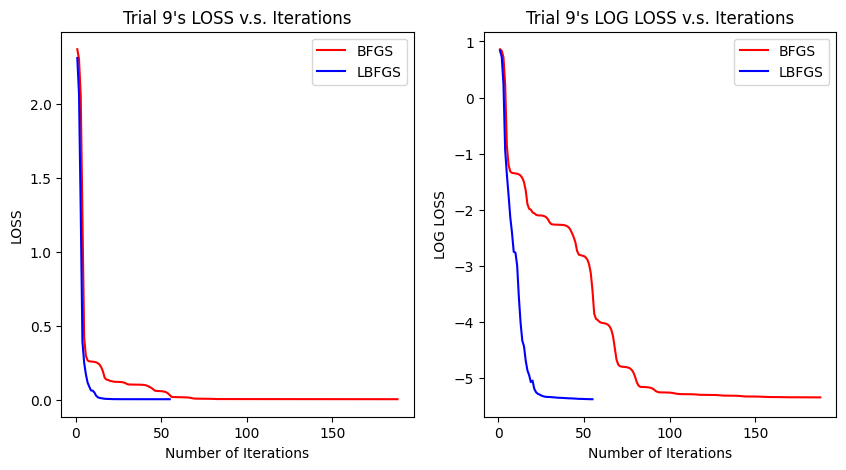

In [153]:
# SETUP 8 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_8[i], all_lbfgs_loss_arrays_8[i])

# Setup 9
Size of Actual Data


In [154]:
#-----------------
# Configuration 9:

# Matrix Size: 288 * 334
# True R SD: 1
# True C SD: 1
# True U/V Mean: 0
# True U/V STD: 1
# Sigma = 0.3
# Missing Proportion: 0.3
# Rank: 3
# Tau: 0.9
# Seed: 100
# R,C initialize with Row/Col mean
#-----------------
rank_9 = 3
tau_9 = 0.9
mu_9 = 0
sd_9 = 1
X_config_9, X_normalized_9, X_new_9, true_r_config_9, true_c_config_9, true_u_congfig_9, true_v_config_9, row_mean_9, col_mean_9 = get_normalized_X(m=288, n=334, r_sd=1, c_sd=1, u_sd=1,v_sd=1,sigma=0.3,na_portion=0.3, rank=rank_9)
all_bfgs_loss_arrays_9, all_lbfgs_loss_arrays_9, all_bfgs_final_loss_9, all_lbfgs_final_loss_9, all_bfgs_predict_array_9, all_lbfgs_predict_array_9 = run_algorithm_ten_trials_sep_init(X_normalized_9, rank_9, tau_9, row_mean_9, col_mean_9, mu_9, sd_9)

MEAN 0.019534200907260785
STD:  2.091206562507181
NEW ERROR_SD:  0.14345785126091284
[[        nan         nan -0.96016784 ...         nan -1.58517008
  -2.03251871]
 [        nan -0.25303502  0.70360114 ...         nan         nan
          nan]
 [ 0.40827864         nan         nan ... -0.2750208          nan
          nan]
 ...
 [        nan         nan  0.97573476 ... -0.03495753  0.54883587
   0.2871279 ]
 [-1.35373302 -1.26339479 -0.37705617 ...         nan         nan
  -1.80388318]
 [ 0.33168904         nan  0.55907672 ...         nan -0.79961268
          nan]]
NEW MEAN:  1.2149491064578515e-17
NEW STD:  1.0
BFGS Final Loss: 0.004778928047905368
SETUP 0 BFGS Takes about:  134.3784122467041  (s)
SETUP 0 BFGS Iterations:  209
------------------------------------
L-BFGS-B Final Loss: 0.004806726069890497
SETUP 0 LBFGS Takes about:  0.1167287826538086  (s)
SETUP 0 LBFGS Iterations:  27

BFGS Final Loss: 0.004801662656205545
SETUP 1 BFGS Takes about:  119.97922658920288  (s)
SETUP 

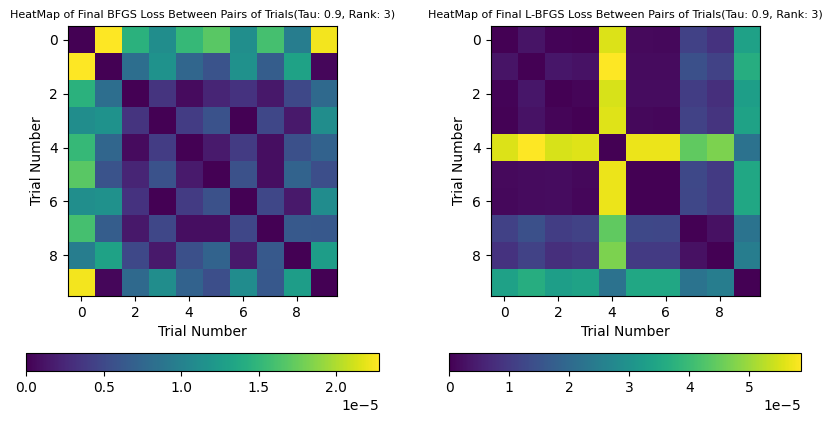

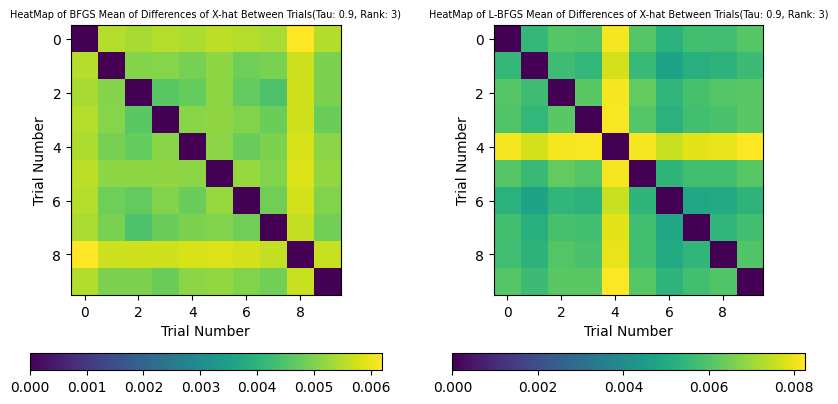

In [157]:
# 9 Setup HeatMap
Plot_HeatMap(all_bfgs_final_loss_9, all_lbfgs_final_loss_9, all_bfgs_predict_array_9, all_lbfgs_predict_array_9, tau_9, rank_9, 288, 334)

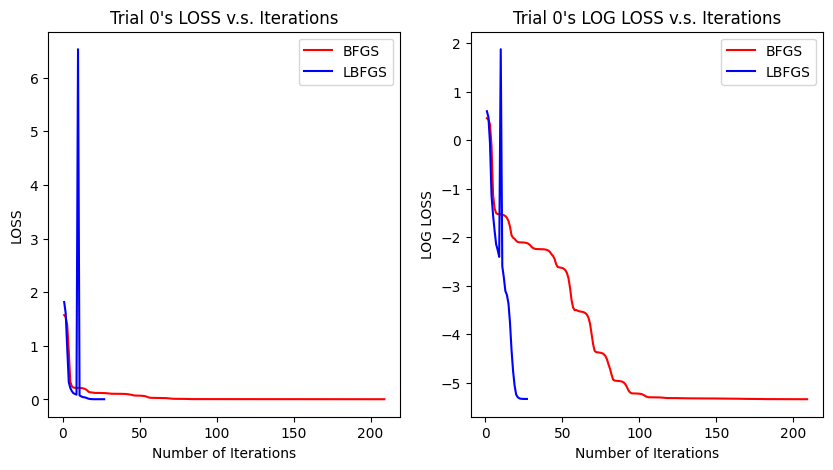

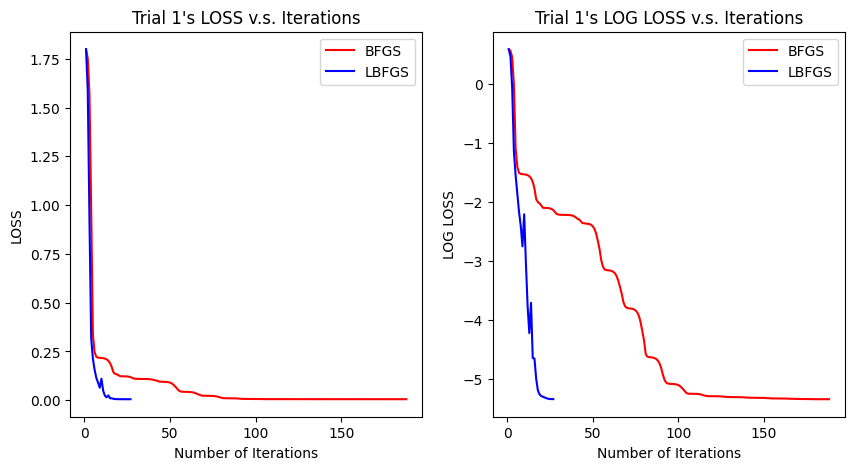

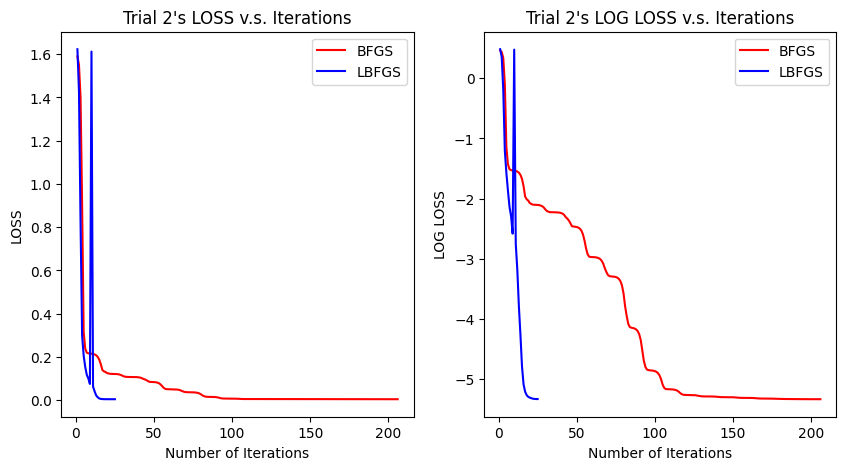

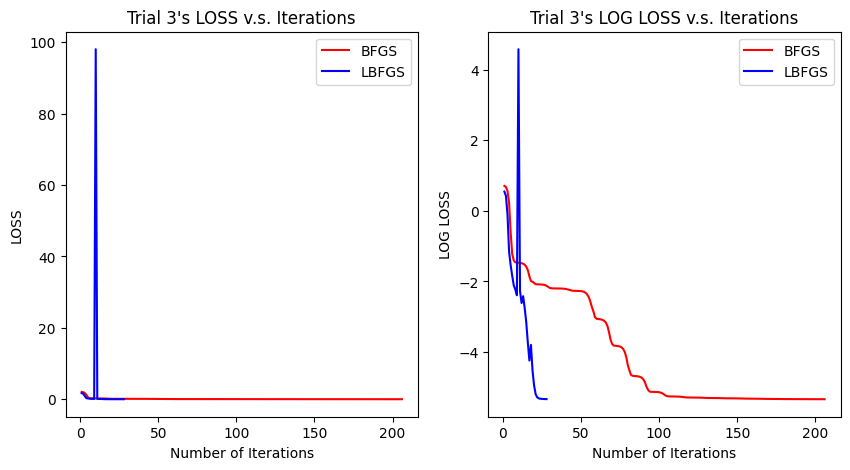

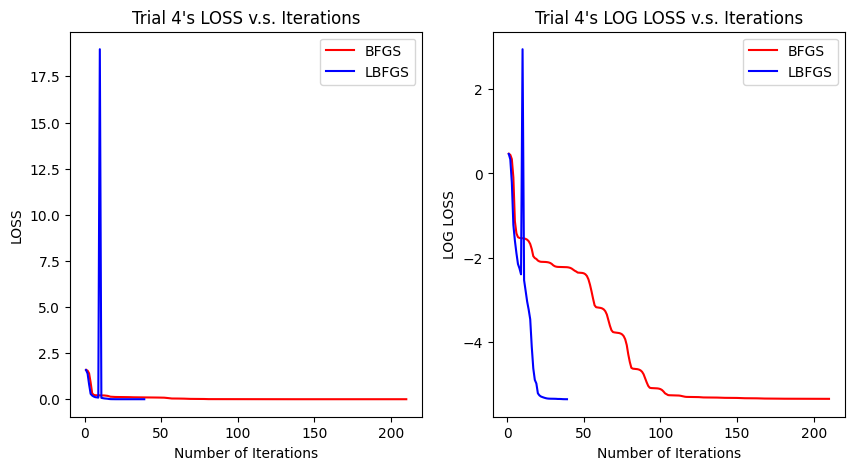

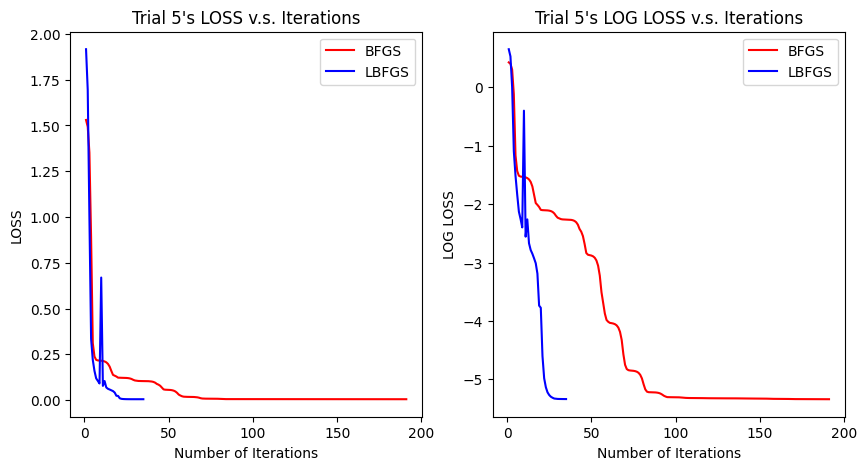

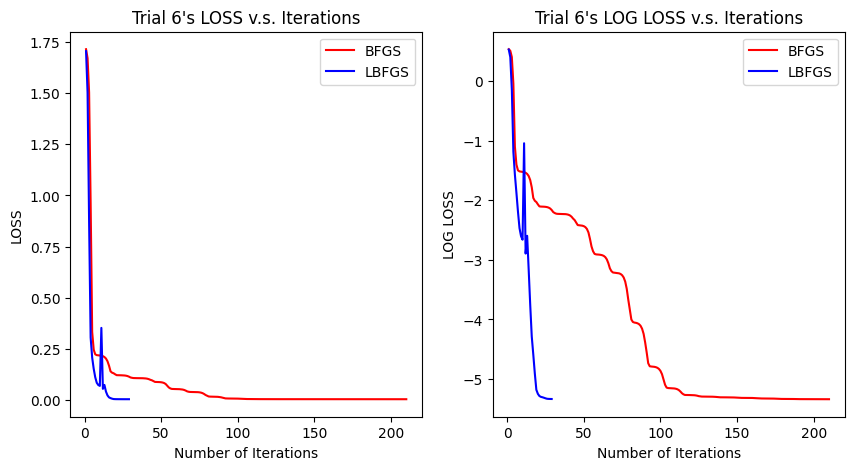

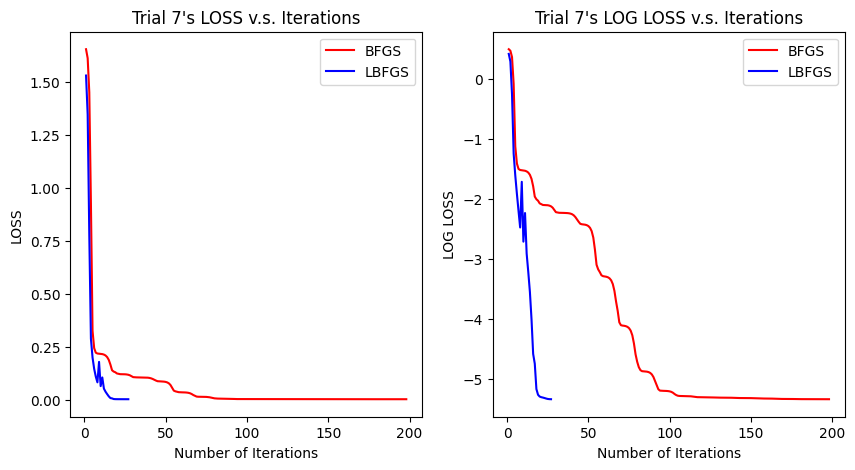

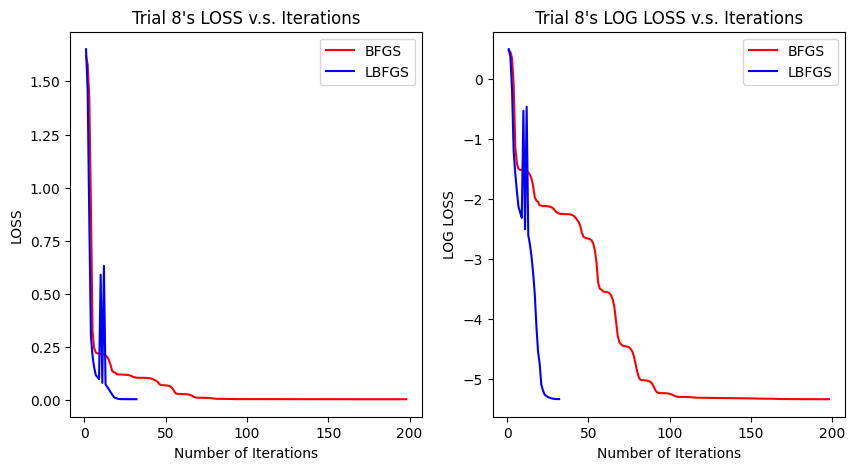

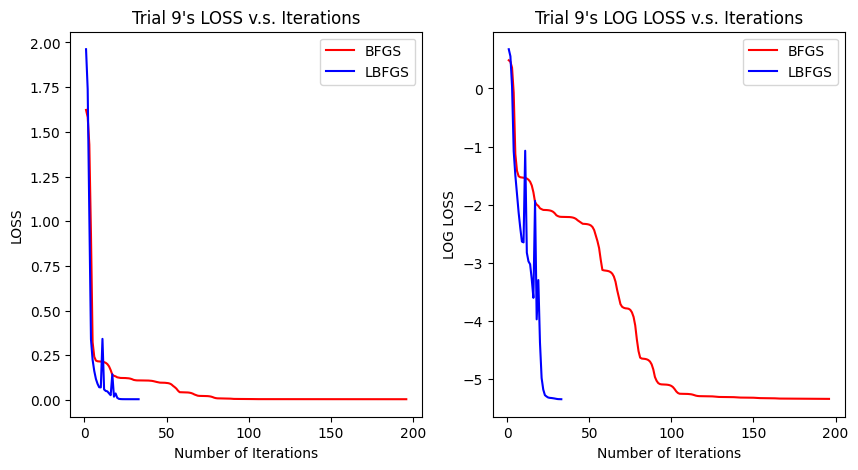

In [158]:
# SETUP 9 Plot
for i in range(10):
  plotter(i, all_bfgs_loss_arrays_9[i], all_lbfgs_loss_arrays_9[i])

In [ ]:
# X_hat = R[:, np.newaxis] + C + U @ V.T
# X_hat

# X_hat_l = R_l[:, np.newaxis] + C_l, + U_l @ V_l.T
# X_hat_l

In [ ]:
# print("BFGS Feature Difference: ", X_hat - mu_X)
# #type(X_hat)
# #X_hat.shape
# residual = (X_hat - mu_X).ravel().std()
# print("BFGS Residual: ", residual)
# #type(residual)
# # plt.hist(residual)
# print("LBFGS Featrue Difference: ", X_hat_l - mu_X)
# residual_l = (X_hat_l - mu_X).ravel().std()
# print("LBFGS Residual: ", residual_l)

In [ ]:
# print("BFGS R's diff: ",true_r - R)
# print("LBFGS R's diff: ", true_r - R_l)

In [ ]:
# print("BFGS C's difference: ", true_c - C)
# print("LBFGS C's difference: ", true_c - C_l)

In [ ]:
# print("BFGS difference in outer: ", np.outer(U, V) - np.outer(true_u, true_v))
# print("LBFGS difference in outer: ", np.outer(U_l, V_l) - np.outer(true_u, true_v))